# Using the digital connector to recreate the Barking & Dagenham manifesto

## Some Background

**The Tombolo project** is a Future Cities Catapult project funded by InnovateUK. It is a research and development project focused on understanding the value of data to unlock the potential of our cities. A big part of the Tombolo project is  the [Digital Connector](http://www.tombolo.org.uk/products/), an open source piece of software for Data Scientists to import and combine datasets into a standard format and model. You can visit the project on [Github](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector) to learn some background as well as instructions on how to use it.


**The Barking & Dagenham manifesto** was developed by London Borough of Barking and Dagenham council in conjuction with its residents and is a set of data driven indices that provides an overview to policy makers of the aspects of society which are important to these residents. To learn more about the different levers of the manifesto please visit the [relevant webpage](https://www.lbbd.gov.uk/council/priorities-and-strategies/borough-manifesto/overview/)


## The goal

This notebook can be viewed as a walkthrough to the process of using the Digital Connector to a real-life application:

* We will fetch the data needed by implementing different data importers
* We will describe a methodology for creating each individual index component  
* We will combine the importers with the index components using the Python bridge to the Digital Connector
* We will visualise the results. 

### Designing and implementing Digital Connector importers

The Digital Connector is essentially a set of data crunching tools that provides seamless interaction between datasets of different formats ands types and the backend geospatial database (postgres). When encounering a new dataset that is not available through the Digital Connector, the user is required to write an ***Importer*** that will be used to download and transform the data into a consistent database schema. The importer will also ensure that the data used have all appropriate matadata that are required to ensure transprency and reproducibility for any subsequent operations. The Tombolo Digital Connector provides convenient tools deal with most common data formats (.csv, .xlsx, .json, .shp etc.) while being flexible enough to deal with less common ones.

A complete walkthrough with step-by-step instructions on how to design a Digital Connector importer using as an example data related to Body Mass Index for the obese from Sports England website is given in the Digital Connector

For this project the following data importers were implemented/used:
* **Skills and Education theme**:
 
    *ONSAverageAttainmentImporter*: Dataset related to average attainment 8 score by local authority provided by ONS     (Department of Education). The dataset is provided as an excel spreadsheet with multiple sheets. The importer that was  implemented assigns the correct geometry for every valid local authority level, and creates a timeseries field for the data. 
    
    *CensusImporter*: This is a bundled importer that is pre-intsalled with the Digital Connector that allows users to access all the latest census data through the NOMIS API. In this case, the dataset QS502EW (Qualifications gained) was used to access the variables "Qualification: NVQ Level 1, Foundation GNVQ, Basic Skills" and "Qualification: NVQ Level 4-5, HNC, HND, RSA Higher Diploma, BTEC Higher Level".
    
    
* **Employment and Enterprise theme**:

    *NOMISBenefitsImporter*: This importer was designed to access the NOMIS API for data related to benefit claimants - employment and support allowance for the 2017 at a local authority level. 
    
     *NOMISEmploymentImporter*: This importer was designed to access the NOMIS API for data related to employment and unemployment rates for the 2017. 

     *NOMISJobsDensityImporter*: This importer was designed to access the NOMIS API for data related to Jobs Density and Total jobs for the 2014-2015. The values were stored as time series.
     
     *ONSBusinessDemographyImporter*: This importer was designed to access the ONS website to fetch data related to business demographics. Due to the unstructured nature of the data, the importer was fine-tuned to extract only the relavant information for this specific manifesto theme (in this case survival of newly born enterprises for the 2012).
     
     *NOMISIncomeImporter*: This importer was designed to access the NOMIS API for data related to gross annual pay  for the 2016-2017. The values were stored as time series.
     
     
* **Environment theme**:

    *WasteDataImporter*: This importer was designed to access the uk.gov website to fetch data related to household waste and recycling rates.  
    
  
* **Health and Well-being theme**:

    *MVPAImporter*: This importer was designed to access the Sports England website to fetch data related physical activity indicators (150-599 MVPA  and 600+ MVPA). The data were fetched using a hardcoded query. The importer assigned the correct local authority geometry by performing a string match on each local authority name.
    
    *NCMPImporter*: This importer was designed to access the Public Health England website to fetch data related to child obesity (Year 6 excess weight). The values were stored as time series.
      
    *NHSAdmissionsImporter*: This importer was designed to access the NHS website to fetch data related to adult obesity and physical activity (Admission Episodes with a primary or secondary diagnosis of obesity, by Region, Local Authority of residence and gender). 

    *ObeseImporter*: This importer was designed to access the  Sports England website to fetch data related to adult obesity (% of people with BMI 30-39.9 kg/m^2). The data were fetched using a hardcoded query. The importer assigned the correct local authority geometry by performing a string match on each local authority name.

    *ONSWellbeingImporter*: This importer was designed to access the  ONS website to fetch data related to wellbeing ("life satisfaction perception", "perception of worthwhile-ness", "happiness perception", "anxiety perception"). 

    *ActivePeopleSurveyCycleImporter*: This importer fetches the proportion of adults who cycle at least once per week data from the Department for Transport. The data are encoded in an .ods format so they had to be reprocessed with an appropriate library 
    
     *ActivePeopleSurveyWalkImporter*: This importer fetches the proportion of how often and how long adults walk for (at least 10 minutes) data by local authority. Same as  the *ActivePeopleSurveyCycleImporter*, the data were reprocessed using a library that can handle .ods formats.

## Methodology for creating each individual index component

The process of implementing importers to fetch non-standardised data from diverse sources ensures that the data are transformed in a unified structure. This enables streamlined further data manipulation. In the context of the Digital Connector, further data manipulation is achieved by implementing combinations of **Fields** that use the attributes of the imported data. Fields have an inherent nested structure in the sense that the final output is the result of a series of hiararchical operations on the data attributes. These operations can be arithmetic, geographical or both. 

The figure below shows the nested structure of making an index component made of two attributes:
* Residual household waste per household (kg/household) 
* Percentage of household waste sent for reuse, recycling or composting

The final index is derived by computing the deciles of final field. The final field is a linear combination of individual components/fields, standardised by deciles. 

In [14]:
from IPython.display import HTML
HTML('<img src="fields.png" height="500" width="1000">')

Here is a quick walkthrough on the reasoning behind choosing the fields in the above diagram. We will go through the nodes unwrapping the nesting from right to left:

* **<font color='red'>LatestValueField</font>:** This is the basic building block of our recipe (our actual data). Its basic attributes as arguments: *label* and *attribute*. A label is the name that we want to give to the variable, and the actual attribute name is the same as encoded through our importer.

* **<font color='red'>GeographicAggregationField</font>:** Unfortunately, our data are not complete throughout the study area. For example, values for City of London local authority in many cases are missing due to statistically insignificant responses. We need a way to deal with this. The Digital Connector has a novel way to achieve this by abstracting a level in geography. In our case, our base geography is local authorities. When we encounter a missing value, we would like to assign the mean of all local authorities in Greater London (this geometry is encoded as england boundaries). The GeographicAggregationField is the base field that allows such an operation. The main arguments are the base subject (local authority), the aggregation function (mean), the field that we are aggregating, and a label.
 
* **<font color='red'>MapToContainingSubjectField</font>:** This field assings the result of the mean value over all local authorities calculated in <font color='red'>GeographicAggregationField</font> to a higher level geometry (in this case england boundaries)

* **<font color='red'>BackOffField</font>:** This field assigns to the missing values the mean value over all local authorities inside Greater London Area. It will ignore the subjects that do have values.

* **<font color='red'>PercentilesField</font>:** This field computes the percentiles of a given field. 

* **<font color='red'>LinearCombinationField</font>:** This field outputs the linear combination of a given number of fields weighted by a vector of scalars.

## Using the Python bridge to the Digital Connector

We will use the diagram above to write a digital connector [recipe](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector/blob/master/documentation/Recipe-Language.md) that will compute the "Combination of Waste Statistics field". A recipe is essential a .json file that includes all instructions to the Digital Connector on how to compute an output file containing the results of data manipulation. We will use the dedicated Python Library that abstracts the creation of the .|json file to simple Python arguments. For reference, at each step we will show the resulted json structure as well as the output of the computation.

### The header file

Every Digital Connector recipe will start with:
* a specification of the importers that are will be used and
* the output geometry, which is referred to as *subject*. In this case, it will be local authorities.



In [18]:
### First we need to specify our imports. We will be interacting with the Digital Connector using subprocess.
### We will be using geopandas and matplotlib to visualise our output
import geopandas as gpd
import subprocess
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

### We load the Python bridge
%run "/Users/tbantis/Desktop/pr1/Thanos data/digital-connector-python/recipe.py"

### Setting up the paths. We will be assuming that the Digital Connector has been cloned on the Desktop:
global gradle_path
global digital_connector_path
gradle_path = '/usr/local/Cellar/gradle/4.1/'
digital_connector_path = 'Desktop/TomboloDigitalConnector/src/main/resources/executions/examples/'
base_dir = str(Path.home())

In [53]:
### subject_geometry is the geometry of our final exporter file. We specify the geometry level and we 
### define a match rule that extracts the Greater London area geometry. 

subject_geometry = Subject(subject_type_label='localAuthority', provider_label='uk.gov.ons',
                  match_rule=Match_Rule(attribute_to_match_on="label", pattern="E090000%"))

### localAuthority is the geometry level that we are interested in. englandGeneralisedBoundaries is the geometry
### of the Greater London area that we will back-off in case of missing data. DefraWaste contains the attributes that
### we will be using. 

localAuthority = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter',
                            datasource_id='localAuthority')
englandGeneralisedBoundaries = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter' ,
                                          datasource_id='englandGeneralisedBoundaries')
DefraWaste = Datasource(importer_class='uk.org.tombolo.importer.manifestoenvironment.WasteImporter' ,
                             datasource_id='DefraWaste')

importers = [localAuthority, englandGeneralisedBoundaries, DefraWaste]

### We will wrap the above in a Dataset object and build the recipe. Notice that there are no fields yet as we haven't 
### specified any
dataset = Dataset(subjects=[subject_geometry], fields=[],
                  datasources=importers)


recipe = Recipe(dataset)
recipe.build_recipe(digital_connector_path +"barking-environment-manifesto_py.json",
                   show=True)

{
  "dataset": {
    "subjects": [
      {
        "subjectType": "localAuthority",
        "provider": "uk.gov.ons",
        "matchRule": {
          "attribute": "label",
          "pattern": "E090000%"
        }
      }
    ],
    "datasources": [
      {
        "importerClass": "uk.org.tombolo.importer.ons.OaImporter",
        "datasourceId": "localAuthority"
      },
      {
        "importerClass": "uk.org.tombolo.importer.ons.OaImporter",
        "datasourceId": "englandGeneralisedBoundaries"
      },
      {
        "importerClass": "uk.org.tombolo.importer.manifestoenvironment.WasteImporter",
        "datasourceId": "DefraWaste"
      }
    ],
    "fields": []
  },
  "exporter": "uk.org.tombolo.exporter.GeoJsonExporter",
  "timeStamp": false
}


Lets pass the above recipe to the Digital Connector and see what we will get. We do that by calling the Digital Connector using subprocess and then use geopandas to visualise our output:

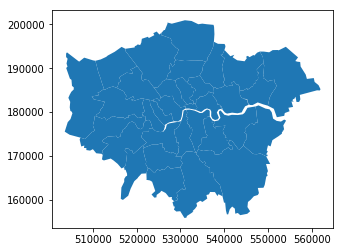

In [103]:
### Naming the output file

output_file = 'barking-environment-manifesto_py'

### Using subprocess.call as it waits for the gradle task to complete. You should be able to see the output in 
### the terminal window

gradle_call = 0 
gradle_call = subprocess.call(gradle_path + 'bin/gradle -p ' +  base_dir + '/Desktop/TomboloDigitalConnector/'  + ' runExport ' + '-PdataExportSpecFile="{0}/{1}{2}.json"'.format(base_dir,digital_connector_path, output_file) + ' -PoutputFile="{0}/Desktop/{1}.json"'.format(base_dir, output_file) +  ' -PclearDatabaseCache=true',
                          shell=True)

### Check if the recipe was build with no errors and if so, read the resulting file and plot it

if gradle_call == 0:
    gdf = gpd.read_file('{0}/Desktop/{1}.json'.format(base_dir, output_file))
    gdf.to_crs(epsg=27700).plot()
else:
    print("gradle task has failed!")

In [26]:
### This is what the output file looks like

gdf.head()

,geometry,label,name
0,"POLYGON ((-0.0784 51.5215, -0.0769 51.5167, -0...",E09000001,City of London
1,"POLYGON ((0.1543 51.5661, 0.1619 51.5616, 0.16...",E09000002,Barking and Dagenham
2,"POLYGON ((-0.1999 51.6702, -0.1911 51.6639, -0...",E09000003,Barnet
3,"POLYGON ((0.1866 51.4804, 0.2008 51.4787, 0.21...",E09000004,Bexley
4,"POLYGON ((-0.258 51.5926, -0.2483 51.5844, -0....",E09000005,Brent


**Congratulations!** You just build your first recipe!

### The main body

Notice that at this stage the the data from our importers are downloaded and imported in the Postgres database but the Digital Connector exports only the base geometry. This is because  we haven't specified any fields yet. The next step is to just export one single attribute from the data downloaded from our WasteImporter:

In [104]:
### We grab the attribute from our importer. We do that by invoking an AttributeMatcher which will essentially look 
### through the database and find the attribute with the corresponding label. 
### Notice that we only need to specify the provider and the attribute label, and the attribute label should
### be the SAME as it appears in the importer (and as an result, in the psql database).

res_household_attribute = AttributeMatcher(provider='uk.gov.defra',
                                     label='Residual household waste per household (kg/household)')

### We then pass the attribute to a LatestValueField field. Digital Connector can store timeseries within the 
### LatestValueField, but we are only interested in the most recent one. Invoking LatestValueField 
### will allow us to extract the latest value of the time series. We can now use any label we wish to name the field.
### For consistency, the label is the same as the attribute in the importer

res_household_field = LatestValueField(attribute_matcher=res_household_attribute,
                         label='Residual household waste per household (kg/household)')

### We now need to specify this field inside our Dataset specification.
### This will specify all the components needed for building a Digital Connector recipe: 
### * The subject geometry (localAuthority)
### * The fields (res_household_field)
### * The datasources (our importers)
### NOTICE that the OaImporters should go first in the list! this is because other importers might depend on the 
### geometry specified by the OaImporters

dataset = Dataset(subjects=[subject_geometry], fields=[res_household_field],
                  datasources=[localAuthority,englandGeneralisedBoundaries,DefraWaste])

### Lets generate the recipe and print it

recipe = Recipe(dataset)
recipe.build_recipe(digital_connector_path + "barking-environment-manifesto_py.json",
                   show=True)




{
  "dataset": {
    "subjects": [
      {
        "subjectType": "localAuthority",
        "provider": "uk.gov.ons",
        "matchRule": {
          "attribute": "label",
          "pattern": "E090000%"
        }
      }
    ],
    "datasources": [
      {
        "importerClass": "uk.org.tombolo.importer.ons.OaImporter",
        "datasourceId": "localAuthority"
      },
      {
        "importerClass": "uk.org.tombolo.importer.ons.OaImporter",
        "datasourceId": "englandGeneralisedBoundaries"
      },
      {
        "importerClass": "uk.org.tombolo.importer.manifestoenvironment.WasteImporter",
        "datasourceId": "DefraWaste"
      }
    ],
    "fields": [
      {
        "fieldClass": "uk.org.tombolo.field.value.LatestValueField",
        "label": "Residual household waste per household (kg/household)",
        "attribute": {
          "provider": "uk.gov.defra",
          "label": "Residual household waste per household (kg/household)"
        }
      }
    ]
  },
  "exp

You can see how the Python bridge works a bit more clearly now. It contains a set of classes that translate the input to the Digital Connector recipe language. This is essentially a nested json file. Lets carry on and run the recipe using the Digital Connector

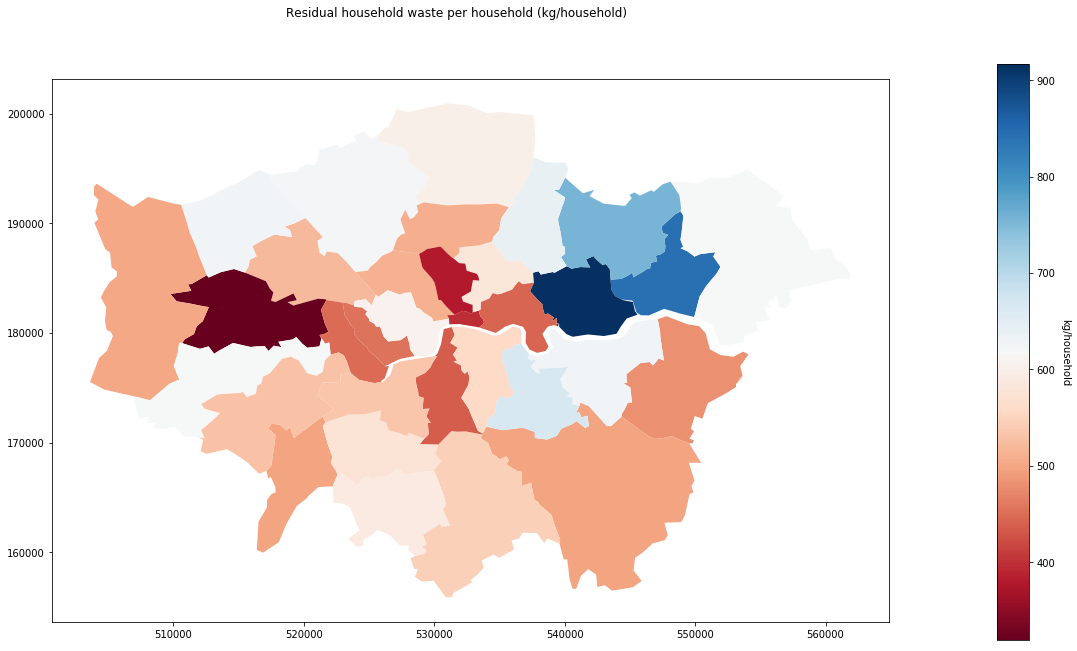

In [105]:
### Naming the output file

output_file = 'barking-environment-manifesto_py'

### Calling the Digital Connector through gradle

gradle_call = 0 
gradle_call = subprocess.call(gradle_path + 'bin/gradle -p ' +  base_dir + '/Desktop/TomboloDigitalConnector/'  + ' runExport ' + '-PdataExportSpecFile="{0}/{1}{2}.json"'.format(base_dir,digital_connector_path, output_file) + ' -PoutputFile="{0}/Desktop/{1}.json"'.format(base_dir, output_file) +  ' -PclearDatabaseCache=true',
                          shell=True)

### If everything worked, use geopandas to load and plot the output

if gradle_call == 0:
    
    ### Specifying the size of the map
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    ### Loading the output file

    gdf = gpd.read_file('{0}/Desktop/{1}.json'.format(base_dir, output_file))
    
    ### Currently, Digital Connector supports only WGS84 coordinate system. We use geopandas
    ### to transform that to OSGB.
    ### Also, notice that we can now the res_household_field is a Python object. This means we can access all
    ### its attributes. We will fetch the label attribute as this is what it is used during data export.
    
    ax = gdf.to_crs(epsg=27700).plot(column=res_household_field.label,
                                cmap='RdBu', linewidth=0.1, ax=ax)
    # add colorbar
    
    cax = fig.add_axes([1, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=gdf['Residual household waste per household (kg/household)'].min(),
                                                               vmax=gdf['Residual household waste per household (kg/household)'].max()))
    sm._A = []
    fig.colorbar(sm, cax=cax).set_label('kg/household', rotation=270)
    cax.get_yaxis().labelpad = 15
    
    # add title
    
    fig.suptitle(res_household_field.label)
    
else:
    print("gradle task has failed!")
    

In [5]:
### Here is what the output looks like

gdf.head()

,name,label,Residual household waste per household (kg/household),geometry
0,Lambeth,E09000022,437.1,"POLYGON ((-0.0993 51.4726, -0.096 51.4699, -0...."
1,Hounslow,E09000018,619.2,"POLYGON ((-0.2742 51.4973, -0.2689 51.494, -0...."
2,Ealing,E09000009,318.9,"POLYGON ((-0.3356 51.5566, -0.3126 51.5492, -0..."
3,Enfield,E09000010,600.6,"POLYGON ((-0.0839 51.69, -0.062 51.683, -0.048..."
4,Lewisham,E09000023,668.3,"POLYGON ((-0.0264 51.4815, -0.023 51.4796, -0...."


In this dataset there are no missing values, but this might not always be the case (for example when we are exploring demographics , City of London usually is not included due to insufficient sample size).  What happens in the case of missing data? We will assign the mean value using the combination of field as specified in our UML diagram flow above:

In [106]:
### Wrapping res_household_field in a GeographicAggregationField

res_household_geo_agg_field = GeographicAggregationField(subject=subject_geometry, field=res_household_field,
                                           function='mean',
                                           label='Aggregation of residual household waste')

### Passing this into a mapToContainingSubjectField. Notice that the subject geometry here is the English boundaries

map_to_containing_subject_field = MapToContainingSubjectField(field=res_household_geo_agg_field,
                                                              subject=Subject(subject_type_label='englandGeneralisedBoundaries',
                                                                                  provider_label='uk.gov.ons'),
                                                              label= 'MapToContainingSubjectField of residual household waste ')

### Finally, we are passing this into a BackOffField that will essentially assign the operation of GeographicAggregationField
### to MapToContainingSubjectField in case of missing data

res_household_backOff_field = BackOffField(fields=[res_household_field, map_to_containing_subject_field],
                            label='Backoff of residual household waste')



Having taken care of the missing values, we will wrap the resulting field in a *PercentilesField* to transform the values in deciles. We need to specify a *normalization_subjects* which in our case will be the local authorities.

In [107]:
### Computing the deciles of 'Residual_household_waste_percentiles'. Notice that we are inverting the distribution
### with inverse=True as more household waste is a negative property for the final index. Also note the normalisation
### subjects arguments: This will renormalise the percentiles according to the subject_geometry provided

res_household_percentiles_field = PercentilesField(field=res_household_backOff_field,
                                                   inverse=True,
                                                   percentile_count=10,
                                                   label='Residual household waste percentiles',
                                                   name="",
                                                   normalization_subjects = [subject_geometry])


Lets run the recipe so far to explore our calculations.

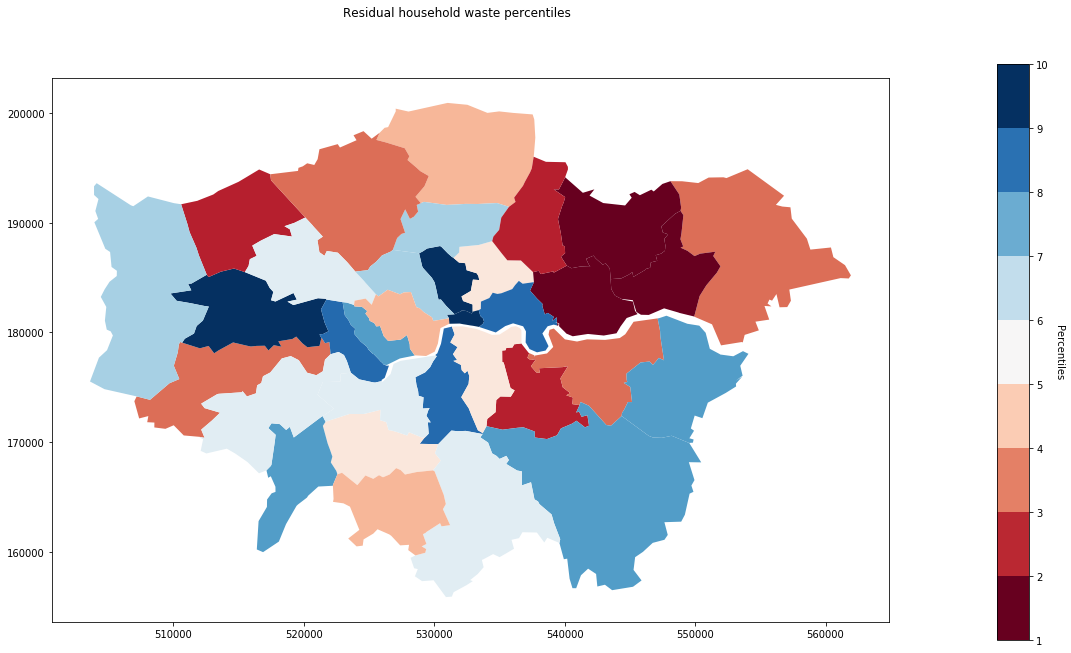

In [110]:
### We wrap all the components needed for building a recipe using the Dataset object

dataset = Dataset(subjects=[subject_geometry], fields=[res_household_percentiles_field],
                  datasources=importers)


### Specifying the output file as well as the recipe name

output_file = 'barking-environment-manifesto_py'

### We build our recipe

recipe = Recipe(dataset)
recipe.build_recipe(digital_connector_path + output_file + ".json",
                   show=False)
### Running the recipe

gradle_call = 0 
gradle_call = subprocess.call(gradle_path + 'bin/gradle -p ' +  base_dir + '/Desktop/TomboloDigitalConnector/'  + ' runExport ' + '-PdataExportSpecFile="{0}/{1}{2}.json"'.format(base_dir,digital_connector_path, output_file) + ' -PoutputFile="{0}/Desktop/{1}.json"'.format(base_dir, output_file) +  ' -PclearDatabaseCache=true',
                          shell=True)

if gradle_call == 0:
    
    ### Reading the output and plotting
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    gdf = gpd.read_file('{0}/Desktop/{1}.json'.format(base_dir, output_file))
    ax = gdf.to_crs(epsg=27700).plot(column=res_household_percentiles_field.label,
                                cmap='RdBu', linewidth=0.1, ax=ax)
    # add colorbar
    cax = fig.add_axes([1, 0.1, 0.03, 0.8])
    norm = colors.BoundaryNorm(boundaries=np.linspace(1,10,10), ncolors=256)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm._A = []
    fig.colorbar(sm, cax=cax).set_label('Percentiles', rotation=270)
    cax.get_yaxis().labelpad = 15
    # add title
    fig.suptitle(res_household_percentiles_field.label)
else:
    print("gradle task has failed!")
    


In [111]:
### This is the first five rows of the exported file

gdf.head()

,Residual household waste percentiles,name,label,geometry
0,9.0,Lambeth,E09000022,"POLYGON ((-0.0993 51.4726, -0.096 51.4699, -0...."
1,3.0,Hounslow,E09000018,"POLYGON ((-0.2742 51.4973, -0.2689 51.494, -0...."
2,10.0,Ealing,E09000009,"POLYGON ((-0.3356 51.5566, -0.3126 51.5492, -0..."
3,4.0,Enfield,E09000010,"POLYGON ((-0.0839 51.69, -0.062 51.683, -0.048..."
4,2.0,Lewisham,E09000023,"POLYGON ((-0.0264 51.4815, -0.023 51.4796, -0...."


Now lets bring in the second dataset for our index 'Percentage of household waste sent for reuse, recycling or composting':

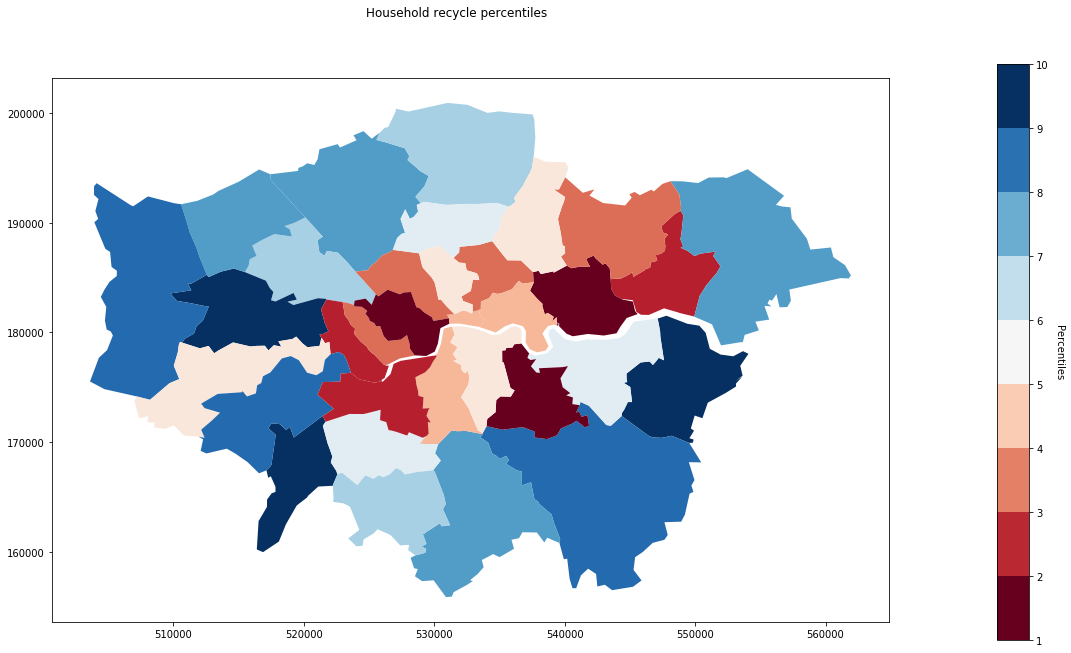

In [113]:
### Creating an AttributeMatcher object that will fetch the required attribute from the importer

household_recycle_attribute = AttributeMatcher(provider='uk.gov.defra',
                                     label='Percentage of household waste sent for reuse, recycling or composting')

### We pass that to a LatestValueField 

household_recycle_field = LatestValueField(attribute_matcher=household_recycle_attribute,
                         label='Percentage of household waste sent for reuse, recycling or composting')

### Taking care of missing values

household_recycle_geo_agg_field = GeographicAggregationField(subject=subject_geometry,
                                                           field=household_recycle_field,
                                                           function='mean',
                                                           label='Aggregation of household recycle')

map_to_containing_subject_field2 = MapToContainingSubjectField(subject=Subject(provider_label='uk.gov.ons',
                                                                              subject_type_label='englishBoundaries'),
                                                              field=household_recycle_geo_agg_field)


household_recycle_backOff_field = BackOffField(fields=[household_recycle_geo_agg_field, map_to_containing_subject_field2],
                            label='Backoff of household recycle')

### We create the percentiles by passing the resulting field into a PercentilesField
### Note that we specify inverse=False as less recycling indicate more deprivation

household_recycle_percentiles_field = PercentilesField(field=household_recycle_backOff_field,
                                                   inverse=False,
                                                   percentile_count=10,
                                                   label='Household recycle percentiles',
                                                   name="",
                                                   normalization_subjects = [subject_geometry])

### We wrap all the required building blocks into a Dataset object

dataset = Dataset(subjects=[subject_geometry], fields=[household_recycle_percentiles_field],
                  datasources=[localAuthority,englandGeneralisedBoundaries,DefraWaste])


output_file = 'barking-environment-manifesto_py'

### We pass the dataset to a Recipe object to build the recipe

recipe = Recipe(dataset)
recipe.build_recipe(digital_connector_path + output_file + ".json",
                   show=False)


### We run the Digital Connector exporter

gradle_call = 0 
gradle_call = subprocess.call(gradle_path + 'bin/gradle -p ' +  base_dir + '/Desktop/TomboloDigitalConnector/'  + ' runExport ' + '-PdataExportSpecFile="{0}/{1}{2}.json"'.format(base_dir,digital_connector_path, output_file) + ' -PoutputFile="{0}/Desktop/{1}.json"'.format(base_dir, output_file) +  ' -PclearDatabaseCache=true',
                          shell=True)

### Plotting the reulting file

if gradle_call == 0:
    ### Reading the output and plotting
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    gdf = gpd.read_file('{0}/Desktop/{1}.json'.format(base_dir, output_file))
    ax = gdf.to_crs(epsg=27700).plot(column=household_recycle_percentiles_field.label,
                                cmap='RdBu', linewidth=0.1, ax=ax)
    # add colorbar
    cax = fig.add_axes([1, 0.1, 0.03, 0.8])
    norm = colors.BoundaryNorm(boundaries=np.linspace(1,10,10), ncolors=256)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm._A = []
    fig.colorbar(sm, cax=cax).set_label('Percentiles', rotation=270)
    cax.get_yaxis().labelpad = 15
    # add title
    fig.suptitle(household_recycle_percentiles_field.label)
else:
    print("gradle task has failed!")
    

Finally lets combine the two percentile fields in one using the linear combination field:

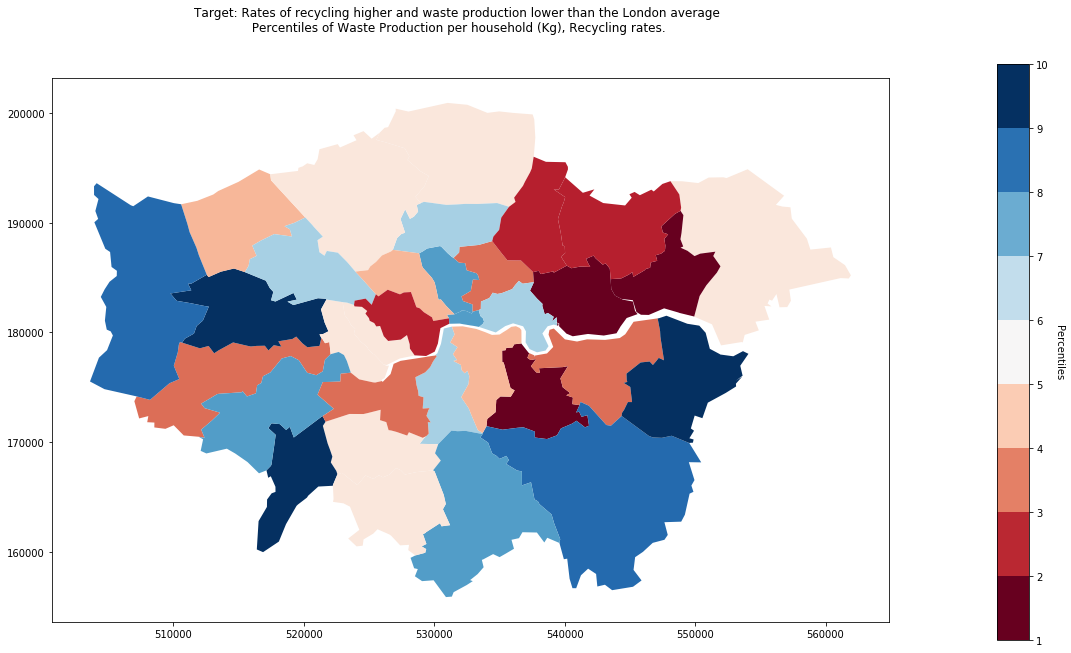

In [114]:
### Creating a LinearCombinationField. This is essintially doing:
### linear_combination_field = scalars[0] * household_recycle_percentiles_field + 
###                            scalars[1] * res_household_percentiles_field

linear_combination_field = LinearCombinationField(label='Rates of recycling higher and waste production lower than the London average',
                                                  scalars=[1.,1.],
                                                  fields=[household_recycle_percentiles_field,
                                                         res_household_percentiles_field])

### Converting the resulting field into percentiles

recycling_waste_field = PercentilesField(field=linear_combination_field,
                                         inverse=False,
                                         normalization_subjects=[subject_geometry],
                                         label='Rates of recycling higher and waste production lower than the London average',
                                         percentile_count=10,
                                         name='')

### Creating the dataset, building the recipe, running the Connector and plotting the results

dataset = Dataset(subjects=[subject_geometry], fields=[recycling_waste_field],
                  datasources=[localAuthority,englandGeneralisedBoundaries,DefraWaste])


output_file = 'barking-environment-manifesto_py'

recipe = Recipe(dataset)
recipe.build_recipe(digital_connector_path + output_file + ".json",
                   show=False)

gradle_call = 0 
gradle_call = subprocess.call(gradle_path + 'bin/gradle -p ' +  base_dir + '/Desktop/TomboloDigitalConnector/'  + ' runExport ' + '-PdataExportSpecFile="{0}/{1}{2}.json"'.format(base_dir,digital_connector_path, output_file) + ' -PoutputFile="{0}/Desktop/{1}.json"'.format(base_dir, output_file) +  ' -PclearDatabaseCache=true',
                          shell=True)


if gradle_call == 0:
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf = gpd.read_file('{0}/Desktop/{1}.json'.format(base_dir, output_file))
    ax = gdf.to_crs(epsg=27700).plot(column='Rates of recycling higher and waste production lower than the London average',
                                cmap='RdBu', linewidth=0.1, ax=ax)
    # add colorbar
    cax = fig.add_axes([1, 0.1, 0.03, 0.8])
    norm = colors.BoundaryNorm(boundaries=np.linspace(1,10,10), ncolors=256)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm._A = []
    fig.colorbar(sm, cax=cax).set_label('Percentiles', rotation=270)
    cax.get_yaxis().labelpad = 15
    # add title
    fig.suptitle('Target: Rates of recycling higher and waste production lower than the London average'+'\n Percentiles of Waste Production per household (Kg), Recycling rates.')
else:
    print("gradle task has failed!")
    

What if we want to normalise our results over East London only? For this we need to create a new Subject geometry that will contain only East London's local authorities. 

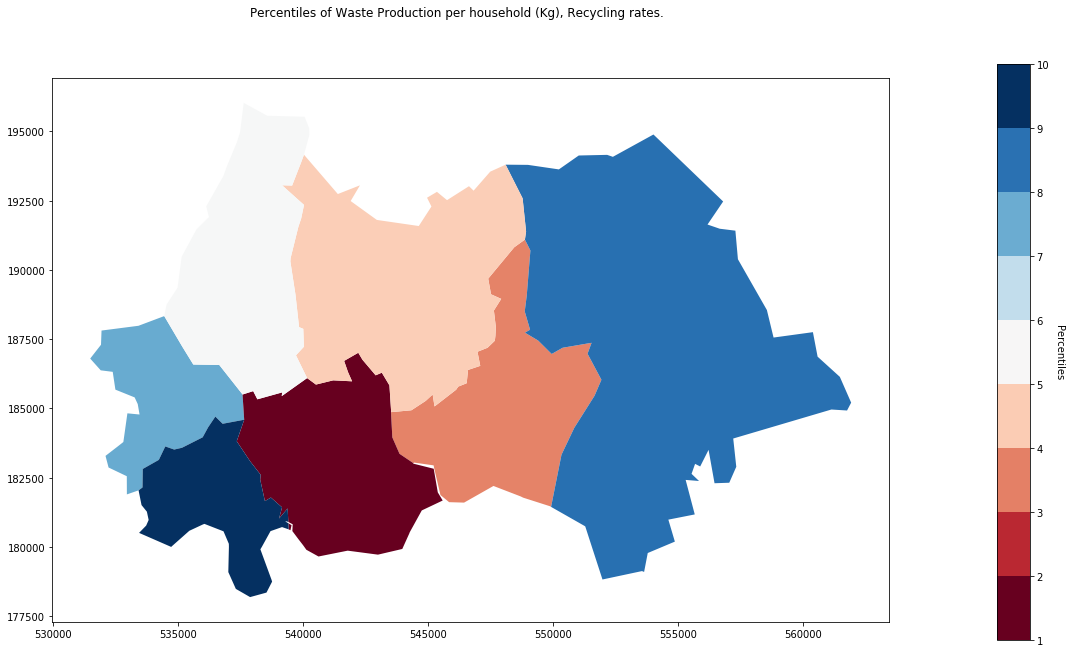

In [115]:
### Subject for the east london only. We have to specify the local authorities that make up east london 
### and perform a union 

east_london = Geo_Match_Rule(geo_relation='within',subjects=[Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Tower Hamlets')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Newham')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Waltham Forest')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Barking and Dagenham')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Redbridge')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Havering')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Hackney'))])

### Wrap them within a Subject object

subject_geometry_east_london = Subject(subject_type_label='localAuthority',
                                       provider_label='uk.gov.ons',
                                       geo_match_rule=east_london)

### Converting the resulting field into percentiles usinh the new Subject 

recycling_waste_field = PercentilesField(field=linear_combination_field,
                                         inverse=False,
                                         normalization_subjects=[subject_geometry_east_london],
                                         label='Rates of recycling higher and waste production lower than the London average',
                                         percentile_count=10,
                                         name='')


### Creating the dataset, building the recipe, running the Connector and plotting the results. 
### Note that our subjects have changed.

dataset = Dataset(subjects=[subject_geometry_east_london], fields=[recycling_waste_field],
                  datasources=[localAuthority,englandGeneralisedBoundaries,DefraWaste])


output_file = 'barking-environment-manifesto_east_london_py'

recipe = Recipe(dataset)
recipe.build_recipe(digital_connector_path + output_file + ".json",
                   show=False)

gradle_call = 0 
gradle_call = subprocess.call(gradle_path + 'bin/gradle -p ' +  base_dir + '/Desktop/TomboloDigitalConnector/'  + ' runExport ' + '-PdataExportSpecFile="{0}/{1}{2}.json"'.format(base_dir,digital_connector_path, output_file) + ' -PoutputFile="{0}/Desktop/{1}.json"'.format(base_dir, output_file) +  ' -PclearDatabaseCache=true',
                          shell=True)


if gradle_call == 0:
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf = gpd.read_file('{0}/Desktop/{1}.json'.format(base_dir, output_file))
    ax = gdf.to_crs(epsg=27700).plot(column='Rates of recycling higher and waste production lower than the London average',
                                cmap='RdBu', linewidth=0.1, ax=ax)
    # add colorbar
    cax = fig.add_axes([1, 0.1, 0.03, 0.8])
    norm = colors.BoundaryNorm(boundaries=np.linspace(1,10,10), ncolors=256)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm._A = []
    fig.colorbar(sm, cax=cax).set_label('Percentiles', rotation=270)
    cax.get_yaxis().labelpad = 15
    # add title
    fig.suptitle('Percentiles of Waste Production per household (Kg), Recycling rates.')
else:
    print("gradle task has failed!")
    

## Let's expand the above methodology to the rest of manifesto's targets

### Health and Well-being
#### Healthy weight better than the East London average

The below code will calculate the Healthy weight better than the East London average target using the following variables:

* Percentage of Year-6 pupils with healthy weight
* Percentage of obese adults
* NHS addmissions where obesity was a factor 

Throughout the notebook, we will be using calls to the Digital Connector quite a lot. It makes sense to wrap them within a Python function. We will do the same for the plotting.

In [116]:
def run_gradle(output_file, dataset):
    '''
    Runs the Digital Connector using a gradle task.
    
    Arguments: 
        output_file: a string containing the name of the output file.
        dataset: A Dataset instance containing all the components needed for the gradle task
        
    Returns: a flag of weather the task has been completed with no errors
    '''
    
    out  = output_file
    recipe = Recipe(dataset)
    recipe.build_recipe(digital_connector_path + output_file + ".json",
                       show=False)

    gradle_call = subprocess.call(gradle_path + 'bin/gradle -p ' +  base_dir + '/Desktop/TomboloDigitalConnector/'  + ' runExport ' + '-PdataExportSpecFile="{0}/{1}{2}.json"'.format(base_dir,digital_connector_path, output_file) + ' -PoutputFile="{0}/Desktop/{1}.json"'.format(base_dir, output_file) +  ' -PclearDatabaseCache=true',
                              shell=True)
    return gradle_call

def plot_result(gradle_call, output_file, field_london, field_east_london, title):
    '''
    Plots the results of the Digital Connector for London and East London.
    Arguments:
        gradle_call: a flag of weather the task has been completed with no errors
        output_file: the name of the output file. 
        field_london: The Digital Connector field to plot for London
        field_east_london: The Digital Connector field to plot for East London
        
    Returns: None
    '''
    if gradle_call == 0:
        fig = plt.figure(figsize=(15, 20))

        ax1 = fig.add_subplot(2,1,1)
        ax2 = fig.add_subplot(2,1,2)

        # London plot
        gdf = gpd.read_file('{0}/Desktop/{1}.json'.format(base_dir, output_file))
        ax1 = gdf.to_crs(epsg=27700).plot(column=field_london.label,
                                cmap='RdBu', linewidth=0.1, ax=ax1)
        ax1.set_title("London")

        # East London plot
        gdf = gpd.read_file('{0}/Desktop/{1}_east_london.json'.format(base_dir, output_file))
        ax2 = gdf.to_crs(epsg=27700).plot(column=field_east_london.label,
                                cmap='RdBu', linewidth=0.1, ax=ax2)
        ax2.set_title("East London")

        # add colorbar
        cax = fig.add_axes([1, 0.1, 0.03, 0.8])
        norm = colors.BoundaryNorm(boundaries=np.linspace(1,10,10), ncolors=256)
        sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
        sm._A = []
        fig.colorbar(sm, cax=cax).set_label('Percentiles', rotation=270)
        cax.get_yaxis().labelpad = 15
        # add title
        fig.suptitle(title)
    else:
        print("gradle task has failed!") 
        

In [117]:
### base geometry

subject_geometry = Subject(subject_type_label='localAuthority', provider_label='uk.gov.ons',
                  match_rule=Match_Rule(attribute_to_match_on="label", pattern="E090000%"))

### Subject for the east london only. We have to specify the local authorities that make up east london 
### and perform a union 

east_london = Geo_Match_Rule(geo_relation='within',subjects=[Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Tower Hamlets')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Newham')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Waltham Forest')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Barking and Dagenham')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Redbridge')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Havering')),
                                             Subject(subject_type_label='localAuthority',
                                                      provider_label='uk.gov.ons',
                                                      match_rule=Match_Rule(attribute_to_match_on='name',
                                                                            pattern='Hackney'))])

### Wrap them within a Subject object

subject_geometry_east_london = Subject(subject_type_label='localAuthority',
                                       provider_label='uk.gov.ons',
                                       geo_match_rule=east_london)


### Importers

localAuthority = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter',
                            datasource_id='localAuthority')
englandGeneralisedBoundaries = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter' ,
                                          datasource_id='englandGeneralisedBoundaries')
MVPAactive = Datasource(importer_class='uk.org.tombolo.importer.manifestohealth.MVPAImporter' ,
                             datasource_id='MVPAactive')
childhoodObesity = Datasource(importer_class='uk.org.tombolo.importer.manifestohealth.NCMPImporter' ,
                             datasource_id='childhoodObesity')
NHSObese = Datasource(importer_class='uk.org.tombolo.importer.manifestohealth.NHSAdmissionsImporter' ,
                             datasource_id='NHSObese')
BMIObese = Datasource(importer_class='uk.org.tombolo.importer.manifestohealth.ObeseImporter' ,
                             datasource_id='BMIObese')
ONSWellbeing = Datasource(importer_class='uk.org.tombolo.importer.manifestohealth.ONSWellbeingImporter' ,
                             datasource_id='ONSWellbeing')
ActivePeopleCycle = Datasource(importer_class='uk.org.tombolo.importer.manifestohealth.ActivePeopleSurveyCycleImporter' ,
                             datasource_id='ActivePeopleCycle')
ActivePeopleWalk = Datasource(importer_class='uk.org.tombolo.importer.manifestohealth.ActivePeopleSurveyWalkImporter' ,
                             datasource_id='ActivePeopleWalk')
### Placing all our importers in a field

importers = [localAuthority,englandGeneralisedBoundaries,MVPAactive,
                              childhoodObesity,NHSObese,BMIObese,ONSWellbeing,ActivePeopleCycle,ActivePeopleWalk]
### Attributes/Fields
### Percentage of Year-6 pupils with healthy weight.
year6_excess_weight_attribute = AttributeMatcher(provider='uk.nhs.phe',
                                     label='year6_excess_weight')

year6_excess_weight_field = LatestValueField(attribute_matcher=year6_excess_weight_attribute,
                         label='Childhood obesity')

### Percentage of obese adults.
obese_adults_attribute = AttributeMatcher(provider='activepeople.sportengland.org',
                                     label='BMI_obesity')

obese_adults_field = LatestValueField(attribute_matcher=obese_adults_attribute,
                         label='Adult obesity')

### NHS addmissions where obesity was a factor (per 1000k p.)
obese_admissions_attribute = AttributeMatcher(provider='digital.nhs.uk',
                                     label='admissions_all')

obese_admissions_field = LatestValueField(attribute_matcher=obese_admissions_attribute,
                         label='Obese admissions')


### Self-perception of Life satisfaction.
life_satisfaction_attribute = AttributeMatcher(provider='uk.gov.ons',
                                     label='life_satisfaction')

life_satisfaction_field = LatestValueField(attribute_matcher=life_satisfaction_attribute,
                         label='Life satisfaction')

### Self-perception of Anxiety.
anxiety_attribute = AttributeMatcher(provider='uk.gov.ons',
                                     label='anxiety')

anxiety_field = LatestValueField(attribute_matcher=anxiety_attribute,
                         label='Anxiety')

### Self-perception of Happiness.
happy_attribute = AttributeMatcher(provider='uk.gov.ons',
                                     label='happy')

happy_field = LatestValueField(attribute_matcher=happy_attribute,
                         label='Happiness')


### Self-perception of Worthiness.
worthwhile_attribute = AttributeMatcher(provider='uk.gov.ons',
                                     label='worthwhile')

worthwhile_field = LatestValueField(attribute_matcher=worthwhile_attribute,
                         label='Worthiness')

### Proportion of  Active Residents  (> 150 min of Moderate or Vigorous of P.A. per week).
active_residents_attribute = AttributeMatcher(provider='activepeople.sportengland.org',
                                     label='MVPA_active')

active_residents_field = LatestValueField(attribute_matcher=active_residents_attribute,
                         label='Active Residents')


### Taking care of missing values for each field

fields = [year6_excess_weight_field, obese_adults_field, obese_admissions_field, life_satisfaction_field,
              happy_field, worthwhile_field, anxiety_field, active_residents_field]

### Wrapping our fields inside dictionaries is a convenient way to deal with lots of importers and fields

g={}
for i in fields:
    g["geo_"+i.label] = GeographicAggregationField(subject=subject_geometry,
                                                           field=i,
                                                           function='mean',
                                                           label='Aggregation of '+i.label)
m={}
for key,value in g.items():
    m["map_"+key] = MapToContainingSubjectField(subject=Subject(provider_label='uk.gov.ons',
                                                                                      subject_type_label='englandGeneralisedBoundaries'),
                                                                      field=value)
    
b={}
for index, key in enumerate(m):
    b["backoff_"+fields[index].label] = BackOffField(fields=[fields[index], m[key]],
                            label='Backoff of '+fields[index].label)
p={}
for key,value in b.items():
    if key in ['backoff_Adult obesity', 'backoff_Childhood obesity', 'backoff_Obese admissions', 
               'backoff_geo_Adult obesity','backoff_Anxiety']:
        p["percentiles_"+key] = PercentilesField(field=value,
                                                 inverse=True,
                                                 percentile_count=10,
                                                 label="percentiles_"+key,
                                                 name="",
                                                 normalization_subjects = [subject_geometry])
    else:
        p["percentiles_"+key] = PercentilesField(field=value,
                                                 inverse=False,
                                                 percentile_count=10,
                                                 label="percentiles_"+key,
                                                 name="",
                                                 normalization_subjects = [subject_geometry])        




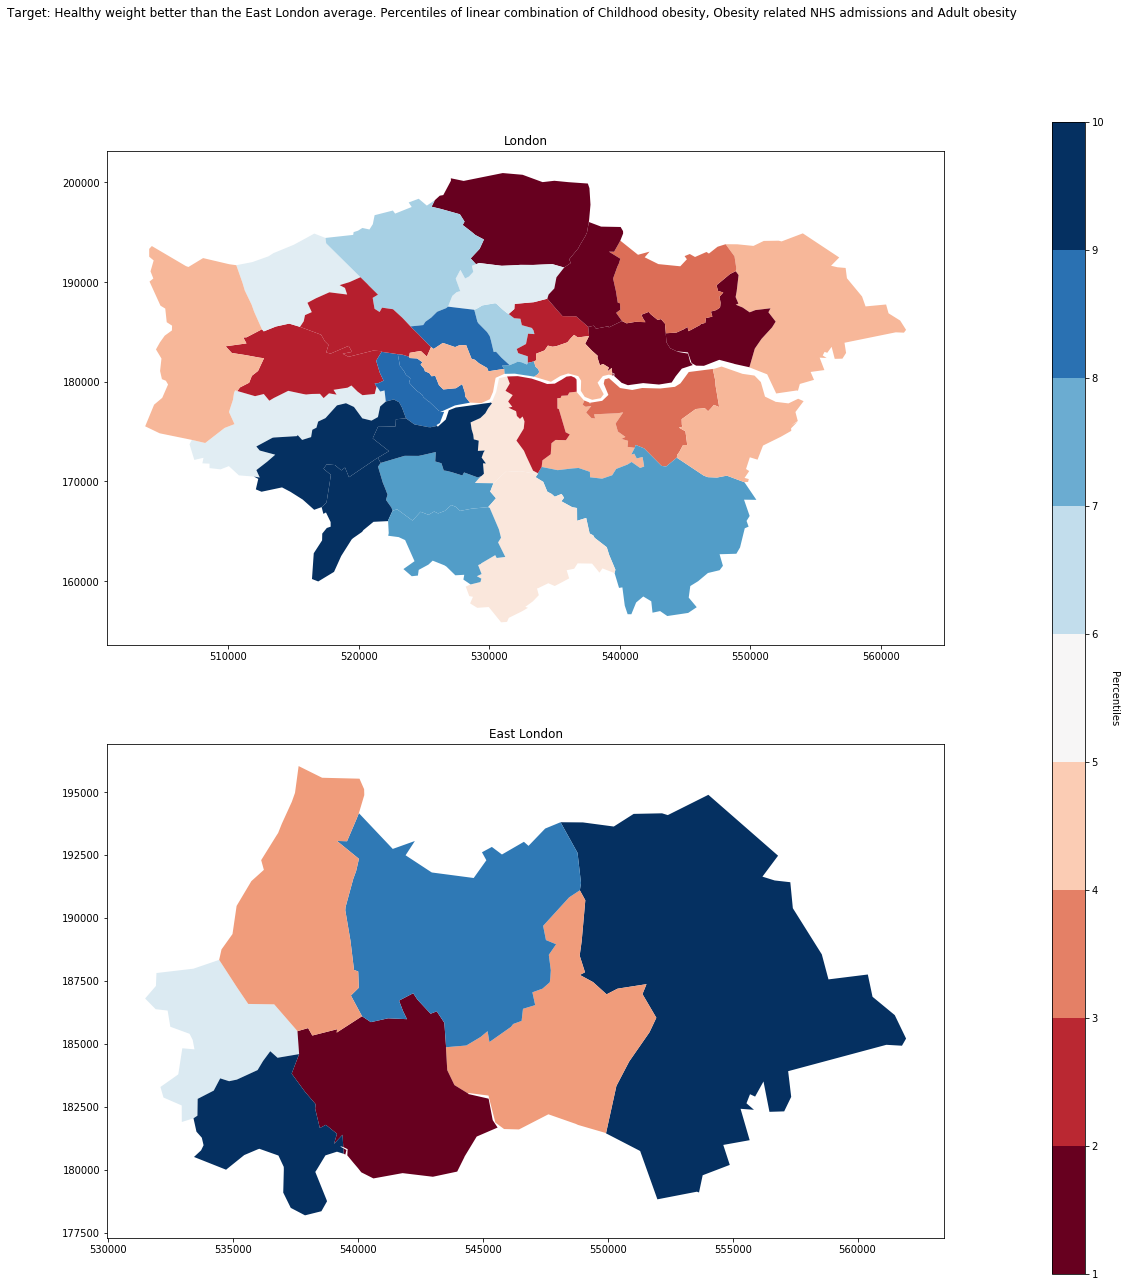

In [118]:
### Creating the LinearCombinationField. Note that now all our fields are in a dictionary, so we referencing them
### by the dictionary key

healthy_weight_linear_comb_field = LinearCombinationField(label='Healthy weight better than the East London average',
                                                  scalars=[1.,1.,1.],
                                                  fields=[p['percentiles_backoff_Childhood obesity'],
                                                      p['percentiles_backoff_Adult obesity'],
                                                      p['percentiles_backoff_Obese admissions']])

healthy_weight_percentiles_field = PercentilesField(field=healthy_weight_linear_comb_field,
                                                    inverse=False,
                                                    percentile_count=10,
                                                    label='Healthy weight better than the East London average',
                                                    normalization_subjects = [subject_geometry])

### Note that we are renormalising according to East London loacl authorities only. This will be reflected in the 
### exported values.

healthy_weight_percentiles_field_east_london = PercentilesField(field=healthy_weight_linear_comb_field,
                                                    inverse=False,
                                                    percentile_count=10,
                                                    label='Healthy weight better than the East London average',
                                                    normalization_subjects = [subject_geometry_east_london])

### Creating two datasets, one London wide and one East London 

dataset = Dataset(subjects=[subject_geometry], fields=[healthy_weight_percentiles_field],
                  datasources=importers)

dataset_east_london = Dataset(subjects=[subject_geometry_east_london],
                              fields=[healthy_weight_percentiles_field_east_london],
                  datasources=importers)


### Wrapping the fields in a Dataset instance for London and East London,  ###
### calling the gradle task and plotting the results  ###

        
output_file = 'barking-health1-manifesto_py'

gradle_call = run_gradle(output_file, dataset)
gradle_call = run_gradle(output_file + '_east_london',
                                      dataset_east_london)

plot_result(gradle_call, output_file,
            healthy_weight_percentiles_field,
            healthy_weight_percentiles_field_east_london,
           'Target: Healthy weight better than the East London average. Percentiles of linear combination of Childhood obesity, Obesity related NHS admissions and Adult obesity')


#### Personal wellbeing and happiness above the London average.

The below code will calculate the Personal wellbeing and happiness above the London average target using the following variables:

* Self-perception of Life satisfaction
* Self-perception of Anxiety
* Self-perception of Happiness
* Self-perception of Worthiness

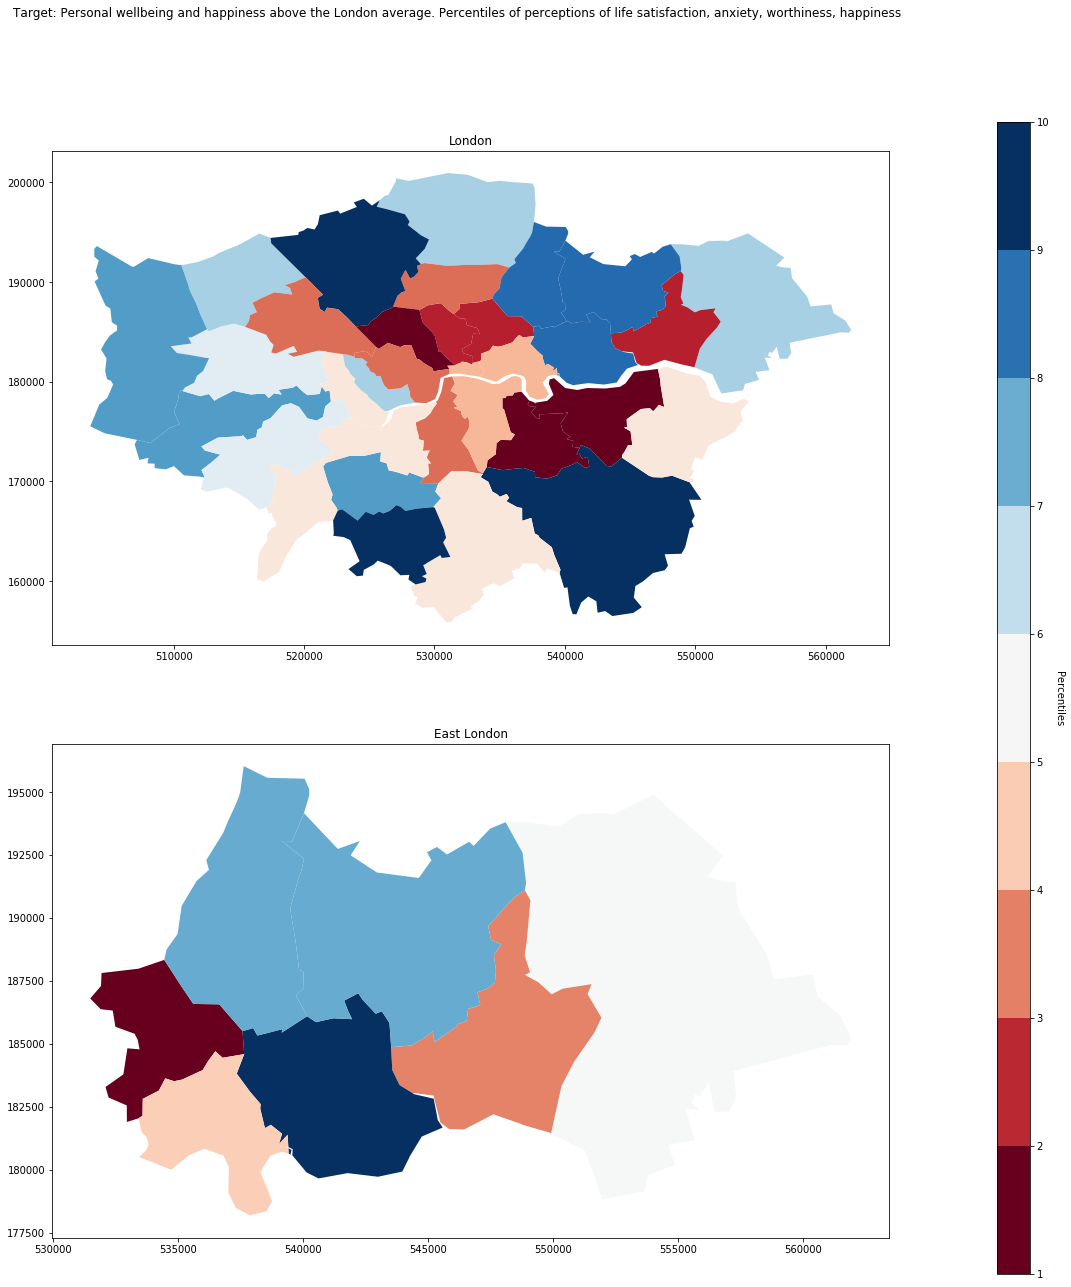

In [117]:
wellbeing_linear_comb_field = LinearCombinationField(label='Personal wellbeing and happiness',
                                                  scalars=[1.,1.,1.,1.],
                                                  fields=[p['percentiles_backoff_Anxiety'],
                                                      p['percentiles_backoff_Happiness'],
                                                      p['percentiles_backoff_Life satisfaction'],
                                                      p['percentiles_backoff_Worthiness']])

wellbeing_percentiles_field = PercentilesField(field=wellbeing_linear_comb_field,
                                                    inverse=False,
                                                    percentile_count=10,
                                                    label='Personal wellbeing and happiness',
                                                    normalization_subjects = [subject_geometry])

wellbeing_percentiles_field_east_london = PercentilesField(field=wellbeing_linear_comb_field,
                                                    inverse=False,
                                                    percentile_count=10,
                                                    label='Personal wellbeing and happiness',
                                                    normalization_subjects = [subject_geometry_east_london])

dataset_london = Dataset(subjects=[subject_geometry], fields=[wellbeing_percentiles_field],
                  datasources=importers)

dataset_east_london = Dataset(subjects=[subject_geometry_east_london],
                               fields=[wellbeing_percentiles_field_east_london],
                  datasources=importers)

### Wrapping the fields in a Dataset instance for London and East London,  ###
### calling the gradle task and plotting the results  ###

        
output_file = 'barking-health2-manifesto_py'

gradle_call = run_gradle(output_file, dataset_london)
gradle_call = run_gradle(output_file + '_east_london',
                                      dataset_east_london)

plot_result(gradle_call, output_file,
            wellbeing_percentiles_field,
            wellbeing_percentiles_field_east_london,
           'Target: Personal wellbeing and happiness above the London average. Percentiles of perceptions of life satisfaction, anxiety, worthiness, happiness')
  

#### Rate of regular physical activity higher than the East London average

The below code will calculate the Rate of regular physical activity higher than the East London average target using the following variables:

* "Proportion of  Active Residents  (> 150 min of Moderate or Vigorous of P.A. per week)
* % of adults that walk at least 10 minutes 5 times a week
* Proportion of adults who cycle at least once per week

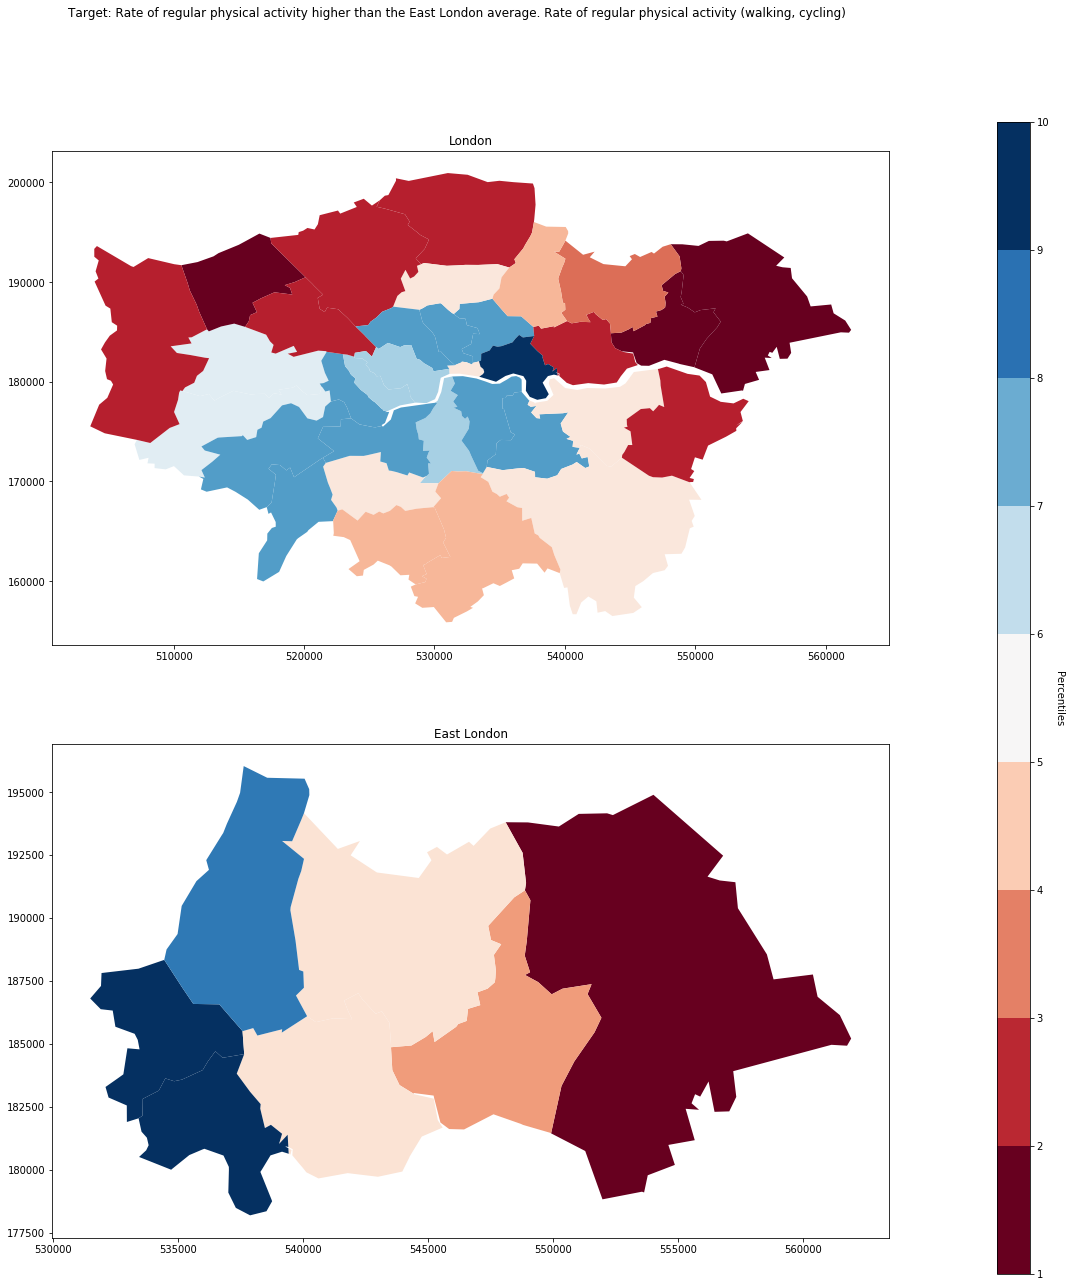

In [119]:
### Attributes/Fields
### percent of people tha walk at least 5 times a week
walk_attribute = AttributeMatcher(provider='uk.gov.dft',
                                     label='walk_x5pw')

walk_field = LatestValueField(attribute_matcher=walk_attribute,
                         label='Walk')

### Proportion of adults who cycle at least once per week
cycle_attribute = AttributeMatcher(provider='uk.gov.dft',
                                     label='cycle_x1pw')

cycle_field = LatestValueField(attribute_matcher=cycle_attribute,
                         label='Cycle')


### Tranforming them to percentiles after taking care of the missing values ###

fields = ['walk_field','cycle_field']

f={}
for i in fields:
    f['geo_{0}'.format(i)] = GeographicAggregationField(subject=subject_geometry,
                                                           field=eval(('{0}').format(i)),
                                                           function='mean',
                                                           label='geo_{0}'.format(i))


    f['map_{0}'.format(i)] = MapToContainingSubjectField(field=f['geo_{0}'.format(i)],
                                                                   subject=Subject(subject_type_label='englandGeneralisedBoundaries',
                                                                                  provider_label='uk.gov.ons'),
                                                                   label='map_{0}'.format(i))

    f['backoff_{0}'.format(i)] = BackOffField(fields=[eval(('{0}').format(i)),
                                                             f['map_{0}'.format(i)]],
                                         label='backoff_{0}'.format(i))
    
    ### London wide normalisation
    
    f['percentile_{0}'.format(i)] = PercentilesField(field=f['backoff_{0}'.format(i)],
                                                     inverse=False,
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry],
                                                     label='percentile_{0}'.format(i))
    ### East London

    f['percentile_{0}_east_london'.format(i)] = PercentilesField(field=f['backoff_{0}'.format(i)],
                                                     inverse=False,
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry_east_london],
                                                     label='percentile_{0}'.format(i))

### Combining the resulting fields with a LinearCombinationField and convering the result to percentiles ###

combined_physical_activity = LinearCombinationField(fields=[f['percentile_walk_field'],
                                                            f['percentile_cycle_field']],
                                                    scalars = [1.,1.],
                                                    label='Rate of regular physical activity for London')

percentile_combined_physical_activity = PercentilesField(field=combined_physical_activity,
                                                     inverse=False,
                                                     label='Rate of regular physical activity for London',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

combined_physical_activity_east_london = LinearCombinationField(fields=[f['percentile_walk_field_east_london'],
                                                                        f['percentile_cycle_field_east_london']],
                                                                scalars = [1.,1.],
                                                                label='Rate of regular physical activity for East London')

percentile_combined_physical_activity_east_london = PercentilesField(field=combined_physical_activity_east_london,
                                                     inverse=False,
                                                     label='Rate of regular physical activity for East London',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry_east_london])

### Pass the the subject geometry, fields and importers in a Dataset object  ###

dataset_london = Dataset(subjects=[subject_geometry], fields=[percentile_combined_physical_activity],
                  datasources=importers)

dataset_east_london = Dataset(subjects=[subject_geometry_east_london], fields=[percentile_combined_physical_activity_east_london],
                  datasources=importers)

### Specifying the output files  ###

output_file = 'barking-health3-manifesto_py'

### Bulding the recipes and running Digital Connector ###

gradle_call = run_gradle(output_file, dataset_london)
gradle_call = run_gradle(output_file + '_east_london',
                                      dataset_east_london)

plot_result(gradle_call, output_file,
            percentile_combined_physical_activity,
            percentile_combined_physical_activity_east_london,
           'Target: Rate of regular physical activity higher than the East London average. Rate of regular physical activity (walking, cycling)')



### Employment and Enterprise
#### Average income improving faster than the London average

The below code will calculate the Average income improving faster than the London average target using the following variables:

* Median gross annual income


In [120]:
### Importers

localAuthority = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter',
                            datasource_id='localAuthority')

englandGeneralisedBoundaries = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter' ,
                                          datasource_id='englandGeneralisedBoundaries')

NOMISIncome = Datasource(datasource_id='NOMISIncome',
                         importer_class='uk.org.tombolo.importer.manifestoemployment.NOMISIncomeImporter')

ONSBusiness = Datasource(datasource_id='ONSBusiness',
                        importer_class='uk.org.tombolo.importer.manifestoemployment.ONSBusinessDemographyImporter')

NOMISJobs = Datasource(datasource_id='NOMISJobs',
                      importer_class='uk.org.tombolo.importer.manifestoemployment.NOMISJobsDensityImporter')

NOMISEmployment = Datasource(datasource_id='NOMISEmployment',
                            importer_class='uk.org.tombolo.importer.manifestoemployment.NOMISEmploymentImporter')

NOMISBenefits = Datasource(datasource_id='NOMISBenefits',
                          importer_class='uk.org.tombolo.importer.manifestoemployment.NOMISBenefitsImporter')

PopulationDensity = Datasource(datasource_id='qs102ew', 
                              importer_class='uk.org.tombolo.importer.ons.CensusImporter')

### Here we are creating a list of the importers that we will be using. NOTE that the importer.ons.OaImporter
### importers have to be the first in the list, as many of the subsequent ones depend on them

importers_list = [localAuthority,englandGeneralisedBoundaries, NOMISIncome, ONSBusiness, NOMISJobs,
                  NOMISEmployment, NOMISBenefits, PopulationDensity]


In [121]:
### Fields

### Calculating percentage of change between 2016-2017 for income
### Formula: increase = Annual_pay_median_2017 - Annual_pay_median_2016
### Annual_pay_median_2016_x_100 = Annual_pay_median_2016 × 100
### %increase = increase ÷ Annual_pay_median_2016_x_100

Annual_pay_median_2017_attribute = AttributeMatcher(label='Annual_pay_median_2017',
                                                   provider='nomisweb.co.uk')
Annual_pay_median_2017_field = LatestValueField(attribute_matcher=Annual_pay_median_2017_attribute,
                                                label='Annual_pay_median_2017_field')

Annual_pay_median_2016_attribute = AttributeMatcher(label='Annual_pay_median_2016',
                                                   provider='nomisweb.co.uk')
Annual_pay_median_2016_field = LatestValueField(attribute_matcher=Annual_pay_median_2016_attribute,
                                                label='Annual_pay_median_2016_field')

years = [Annual_pay_median_2017_field,Annual_pay_median_2016_field]

### Tranforming them to percentiles after taking care of the missing values ###

f={}
for i in years:
    f["geo_"+i.label] = GeographicAggregationField(subject=subject_geometry,
                                                           field=i,
                                                           function='mean',
                                                           label='geo_'+i.label)
    


    f["map_"+i.label] = MapToContainingSubjectField(field=f["geo_"+i.label],
                                                                   subject=Subject(subject_type_label='englandGeneralisedBoundaries',
                                                                                  provider_label='uk.gov.ons'),
                                                                   label="map_"+i.label)

    f["backoff_"+i.label] = BackOffField(fields=[i, f["map_"+i.label]],
                                         label="backoff_"+i.label)



increase_Annual_pay_median_field = ArithmeticField(operation='sub',
                                                   operation_on_field_1=f['backoff_Annual_pay_median_2017_field'],
                                                   operation_on_field_2=f['backoff_Annual_pay_median_2016_field'],
                                                   label = 'increase_Annual_pay_median_field')


mult_Annual_pay_median_2016_field_x100 = ArithmeticField(operation='mul',
                                                         operation_on_field_1=f['backoff_Annual_pay_median_2016_field'],
                                                         operation_on_field_2=FixedAnnotationField(label='Constant',value=100),
                                                         label='mult_Annual_pay_median_2016_field_x100')

percent_increase_field = ArithmeticField(operation='div',
                                             operation_on_field_1=increase_Annual_pay_median_field,
                                             operation_on_field_2=mult_Annual_pay_median_2016_field_x100,
                                             label = 'percent_increase_field')


percentile_percent_increase_field = PercentilesField(field=percent_increase_field,
                                                     inverse=True,
                                                     label='percentile_percent_increase_field',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

percentile_percent_increase_east_london = PercentilesField(field=percent_increase_field,
                                                     inverse=True,
                                                     label='percentile_percent_increase_field_east_london',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry_east_london])



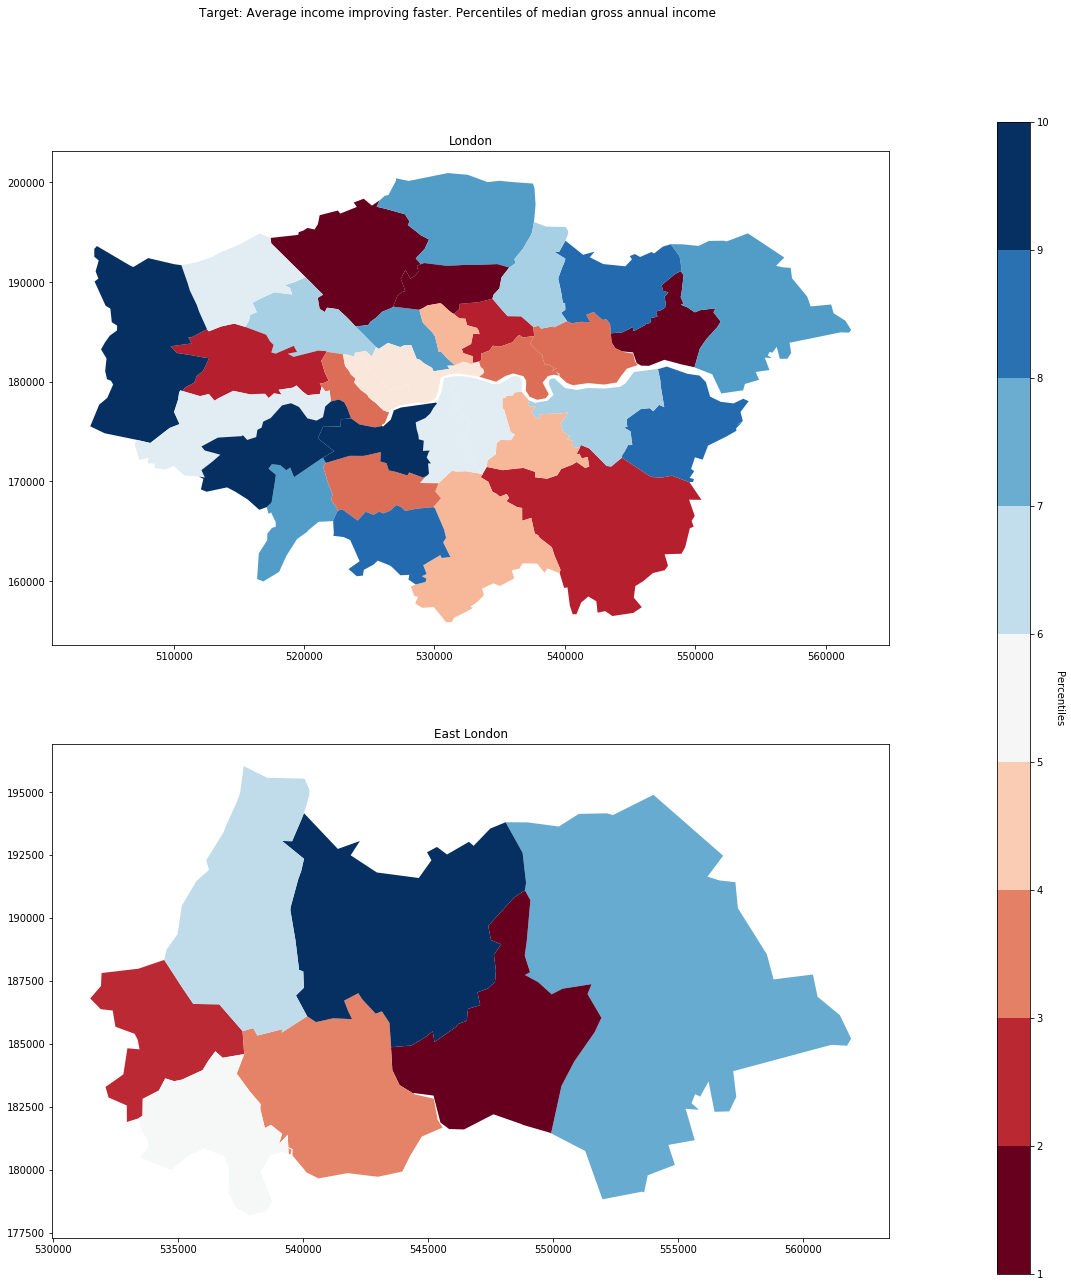

In [122]:
### Wrapping the fields in a Dataset instance for London and East London,  ###
### calling the gradle task and plotting the results  ###

dataset_london = Dataset(subjects=[subject_geometry], fields=[percentile_percent_increase_field],
                  datasources=importers_list)

dataset_east_london = Dataset(subjects=[subject_geometry_east_london], fields=[percentile_percent_increase_east_london],
                  datasources=importers_list)
        
output_file = 'barking-employment1-manifesto_py'

gradle_call = run_gradle(output_file, dataset_london)
gradle_call = run_gradle(output_file + '_east_london',
                                      dataset_east_london)

plot_result(gradle_call, output_file,
            percentile_percent_increase_field,
            percentile_percent_increase_east_london,
           'Target: Average income improving faster. Percentiles of median gross annual income')
 

#### Growth in businesses larger than the East London average

The below code will calculate the "Growth in businesses larger than the East London average" target using the following variables:

* Percentage of new businesses which survive five years above
* Total jobs growth
* Business density (number of VAT registered businesses relative to employment base)

In [123]:
### Fields ###

### Defining our attributes and passing them to fields ###

### Percentage of new businesses which survive five years above

new_business_survival_attribute = AttributeMatcher(label='new_business_survival',
                                                   provider='uk.gov.ons')
new_business_survival = LatestValueField(attribute_matcher=new_business_survival_attribute,
                                                label='new_business_survival')

### Total jobs growth for 2014/2015

total_jobs_2014_attribute = AttributeMatcher(label='total_jobs_2014',
                                                   provider='nomisweb.co.uk')
total_jobs_2014 = LatestValueField(attribute_matcher=total_jobs_2014_attribute,
                                                label='total_jobs_2014')

total_jobs_2015_attribute = AttributeMatcher(label='total_jobs_2015',
                                                   provider='nomisweb.co.uk')
total_jobs_2015 = LatestValueField(attribute_matcher=total_jobs_2015_attribute,
                                                label='total_jobs_2015')

### Business density for 2014/2015

job_density_2014_attribute = AttributeMatcher(label='job_density_2014',
                                                   provider='nomisweb.co.uk')
job_density_2014 = LatestValueField(attribute_matcher=job_density_2014_attribute,
                                                label='total_jobs_2014')

job_density_2015_attribute = AttributeMatcher(label='job_density_2015',
                                                   provider='nomisweb.co.uk')
job_density_2015 = LatestValueField(attribute_matcher=job_density_2015_attribute,
                                                label='job_density_2015')



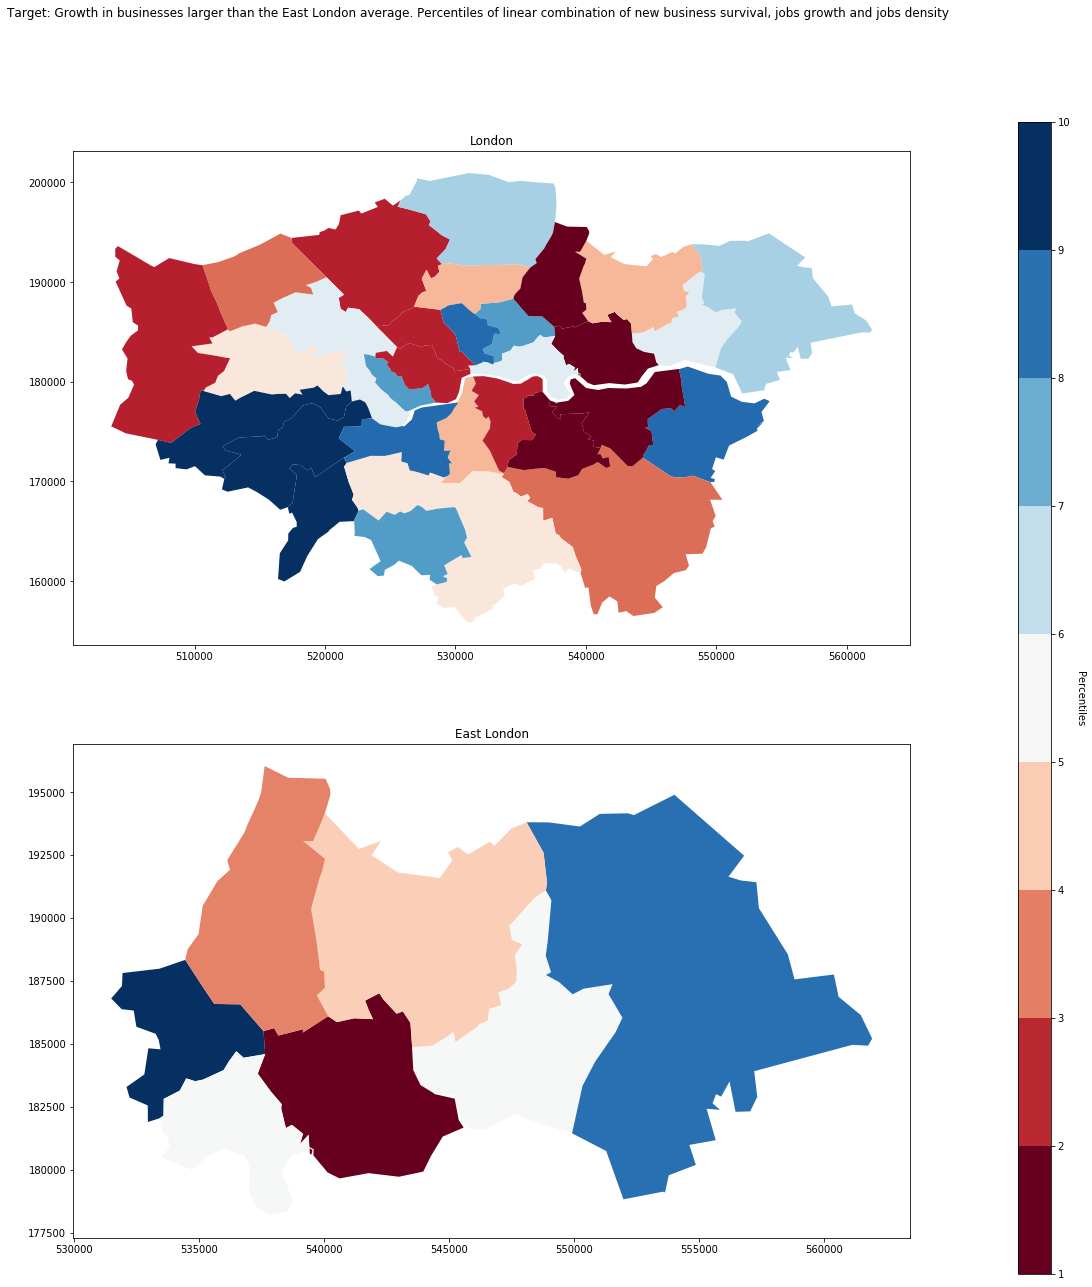

In [124]:
### Calculating the rate of change between 2014/2015 for jobs growth and jobs density ###

years = [2015,2014]
growth = ['total_jobs','job_density']

f={}
for i in years:
    for j in growth:
        f['geo_{0}_{1}'.format(j, i)] = GeographicAggregationField(subject=subject_geometry,
                                                               field=eval(('{0}_{1}').format(j, i)),
                                                               function='mean',
                                                               label='geo_{0}_{1}'.format(j, i))


        f['map_{0}_{1}'.format(j, i)] = MapToContainingSubjectField(field=f['geo_{0}_{1}'.format(j, i)],
                                                                       subject=Subject(subject_type_label='englandGeneralisedBoundaries',
                                                                                      provider_label='uk.gov.ons'),
                                                                       label='map_{0}_{1}'.format(j, i))

        f['backoff_{0}_{1}'.format(j, i)] = BackOffField(fields=[eval(('{0}_{1}').format(j, i)),
                                                                 f['map_{0}_{1}'.format(j, i)]],
                                             label='backoff_{0}_{1}'.format(j, i))


increase_total_jobs = ArithmeticField(operation='sub',
                                                   operation_on_field_1=f['backoff_total_jobs_2015'],
                                                   operation_on_field_2=f['backoff_total_jobs_2014'],
                                                   label = 'increase_total_jobs')

increase_job_density = ArithmeticField(operation='sub',
                                                   operation_on_field_1=f['backoff_job_density_2015'],
                                                   operation_on_field_2=f['backoff_job_density_2014'],
                                                   label = 'increase_job_density')

mult_total_jobs_field_x100 = ArithmeticField(operation='mul',
                                                         operation_on_field_1=f['backoff_total_jobs_2014'],
                                                         operation_on_field_2=FixedAnnotationField(label='Constant',value=100),
                                                         label='mult_total_jobs_field_x100')

mult_job_density_x100 = ArithmeticField(operation='mul',
                                                         operation_on_field_1=f['backoff_job_density_2014'],
                                                         operation_on_field_2=FixedAnnotationField(label='Constant',value=100),
                                                         label='mult_job_density_x100')

percent_increase_total_jobs = ArithmeticField(operation='div',
                                             operation_on_field_1=increase_total_jobs,
                                             operation_on_field_2=mult_total_jobs_field_x100,
                                             label = 'percent_increase_total_jobs')
percent_increase_job_density = ArithmeticField(operation='div',
                                             operation_on_field_1=increase_job_density,
                                             operation_on_field_2=mult_job_density_x100,
                                             label = 'percent_increase_job_density')

### Converting the fields to percentiles ###

percentile_new_business_survival = PercentilesField(field=new_business_survival,
                                                     inverse=False,
                                                     label='percentile_new_business_survival',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

percentile_increase_total_jobs = PercentilesField(field=percent_increase_total_jobs,
                                                     inverse=False,
                                                     label='percentile_increase_total_jobs',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

percentile_increase_job_density = PercentilesField(field=percent_increase_job_density,
                                                     inverse=False,
                                                     label='percentile_increase_job_density',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

### Combining the resulting fields with a LinearCombinationField and convering the result to percentiles ###

businness_growth = LinearCombinationField(fields=[percentile_new_business_survival,
                                                 percentile_increase_total_jobs,
                                                 percentile_increase_job_density],
                                         scalars = [1.,1.,1.],
                                         label='Growth in businesses larger than the East London average')

percentile_businness_growth = PercentilesField(field=businness_growth,
                                                     inverse=False,
                                                     label='Growth in businesses',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

percentile_businness_growth_east_london = PercentilesField(field=businness_growth,
                                                     inverse=False,
                                                     label='Growth in businesses East London',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry_east_london])

### Run the exporter and plot the result ###


dataset_london = Dataset(subjects=[subject_geometry], fields=[percentile_businness_growth],
                  datasources=importers_list)

dataset_east_london = Dataset(subjects=[subject_geometry_east_london], fields=[percentile_businness_growth_east_london],
                  datasources=importers_list)

output_file = 'barking-employment2-manifesto_py'

gradle_call = run_gradle(output_file, dataset_london)
gradle_call = run_gradle(output_file + '_east_london',
                                      dataset_east_london)

plot_result(gradle_call, output_file,
            percentile_businness_growth,
            percentile_businness_growth_east_london,
           'Target: Growth in businesses larger than the East London average. Percentiles of linear combination of new business survival, jobs growth and jobs density')


#### Unemployment lower than the East London average

The below code will calculate the "Unemployment lower than the East London average" target using the following variables:

* Unemployment rate
* Employment rate
* % people claiming Employment and Support Allowance (ESA)

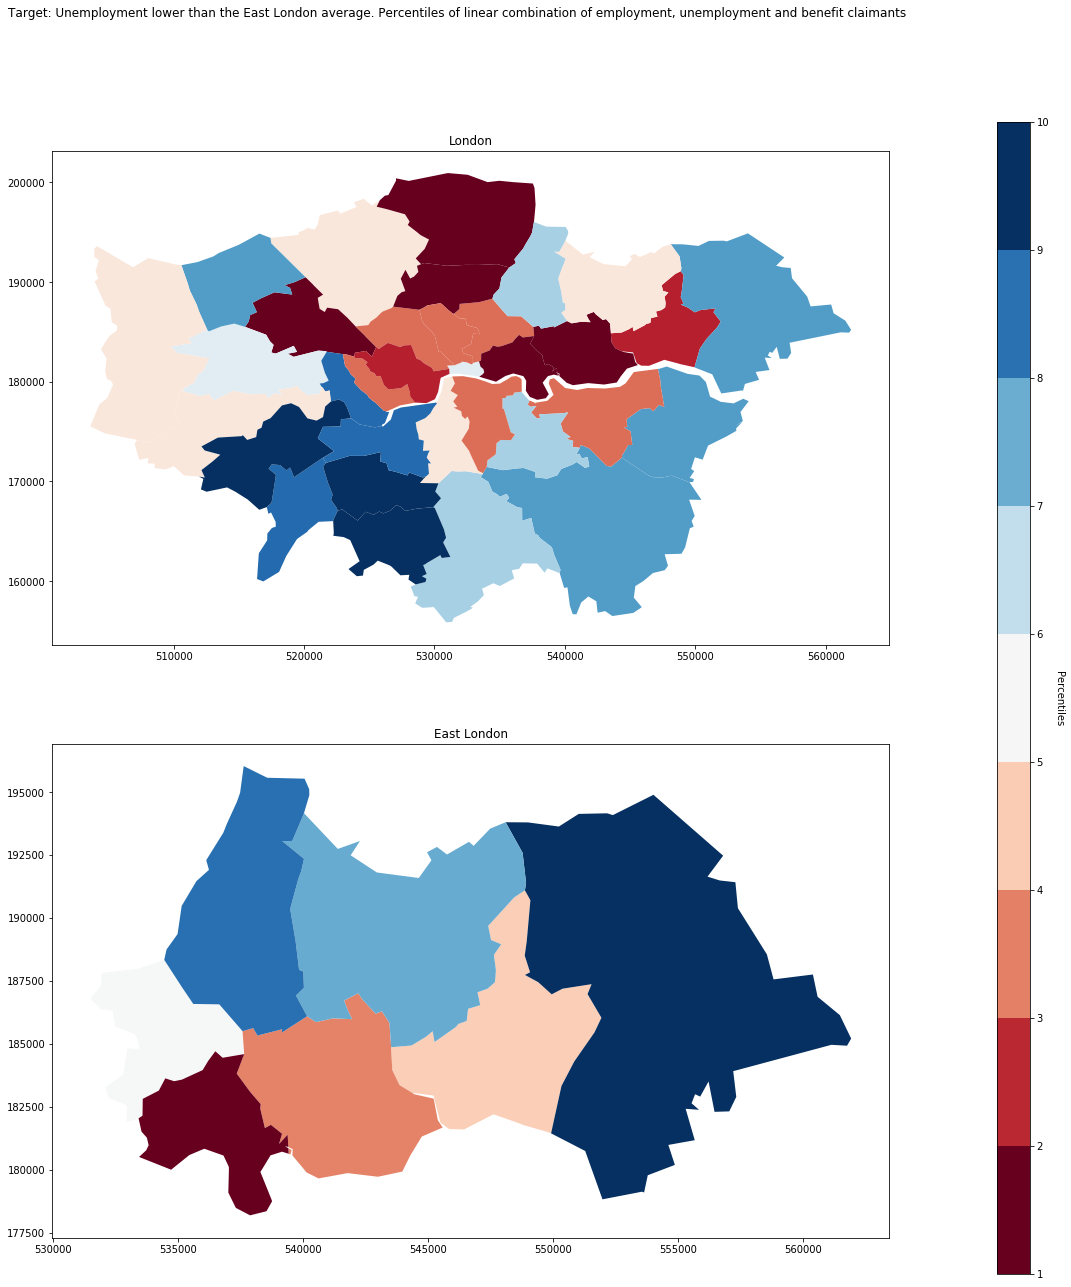

In [125]:
### Fields ###

### Defining our attributes and passing them to fields ###

### Unemployment 

unemployment_attribute = AttributeMatcher(label='unemployment_2016',
                                                   provider='nomisweb.co.uk')
unemployment = LatestValueField(attribute_matcher=unemployment_attribute,
                                                label='unemployment_2016')

### Employment 

employment_attribute = AttributeMatcher(label='employment_2016',
                                                   provider='nomisweb.co.uk')
employment = LatestValueField(attribute_matcher=employment_attribute,
                                                label='employment_2016')

### Claiming allowance 

claimants_attribute = AttributeMatcher(label='benefit_claimants_2017',
                                                   provider='nomisweb.co.uk')
claimants = LatestValueField(attribute_matcher=claimants_attribute,
                                                label='benefit_claimants_2017')


### Tranforming them to percentiles after taking care of the missing values ###

fields = ['unemployment','employment', 'claimants']

f={}
for i in fields:
    f['geo_{0}'.format(i)] = GeographicAggregationField(subject=subject_geometry,
                                                           field=eval(('{0}').format(i)),
                                                           function='mean',
                                                           label='geo_{0}'.format(i))


    f['map_{0}'.format(i)] = MapToContainingSubjectField(field=f['geo_{0}'.format(i)],
                                                                   subject=Subject(subject_type_label='englandGeneralisedBoundaries',
                                                                                  provider_label='uk.gov.ons'),
                                                                   label='map_{0}'.format(i))

    f['backoff_{0}'.format(i)] = BackOffField(fields=[eval(('{0}').format(i)),
                                                             f['map_{0}'.format(i)]],
                                         label='backoff_{0}'.format(i))
    if i == 'employment':
        f['percentile_{0}'.format(i)] = PercentilesField(field=f['backoff_{0}'.format(i)],
                                                         inverse=False,
                                                         percentile_count=10,
                                                         normalization_subjects=[subject_geometry],
                                                         label='percentile_{0}'.format(i))
    else:
        f['percentile_{0}'.format(i)] = PercentilesField(field=f['backoff_{0}'.format(i)],
                                                         inverse=True,
                                                         percentile_count=10,
                                                         normalization_subjects=[subject_geometry],
                                                         label='percentile_{0}'.format(i))        


### Combining the resulting fields with a LinearCombinationField and convering the result to percentiles ###

combined_employment = LinearCombinationField(fields=[f['percentile_claimants'],
                                                 f['percentile_employment'],
                                                 f['percentile_unemployment']],
                                         scalars = [1.,1.,1.],
                                         label='Unemployment lower than the East London average')

percentile_combined_employment = PercentilesField(field=combined_employment,
                                                     inverse=False,
                                                     label='Unemployment lower than the East London average',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

percentile_combined_employment_east_london = PercentilesField(field=combined_employment,
                                                     inverse=False,
                                                     label='Unemployment lower than the East London average',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry_east_london])
### Run the exporter and plot the result ###

dataset_london = Dataset(subjects=[subject_geometry], fields=[percentile_combined_employment],
                  datasources=importers_list)
dataset_east_london = Dataset(subjects=[subject_geometry_east_london], fields=[percentile_combined_employment_east_london],
                  datasources=importers_list)

output_file = 'barking-employment3-manifesto_py'

gradle_call = run_gradle(output_file, dataset_london)
gradle_call = run_gradle(output_file + '_east_london',
                                      dataset_east_london)

plot_result(gradle_call, output_file,
            percentile_combined_employment,
            percentile_combined_employment_east_london,
           'Target: Unemployment lower than the East London average. Percentiles of linear combination of employment, unemployment and benefit claimants')


### Skills and Education
#### Educational attainment at all levels better than the London average

The below code will calculate the Average income improving faster than the London average target using the following variables:

* People with Level 1 and above
* People with Level 4 and above
* Attainment 8 score per pupil

In [126]:
### Importers

localAuthority = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter',
                            datasource_id='localAuthority')

englandGeneralisedBoundaries = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter' ,
                                          datasource_id='englandGeneralisedBoundaries')

# Importer for the ONS Census dataset for population density

education = Datasource(datasource_id='qs502ew',
                         importer_class='uk.org.tombolo.importer.ons.CensusImporter')

ONSAverageAttainment = Datasource(datasource_id='ONSAverageAttainment',
                        importer_class='uk.org.tombolo.importer.manifestoeducation.ONSAverageAttainmentImporter')


### Here we are creating a list of the importers that we will be using. NOTE that the importer.ons.OaImporter
### importers have to be the first in the list, as many of the subsequent ones depend on them

importers_list = [localAuthority,englandGeneralisedBoundaries, education, ONSAverageAttainment]

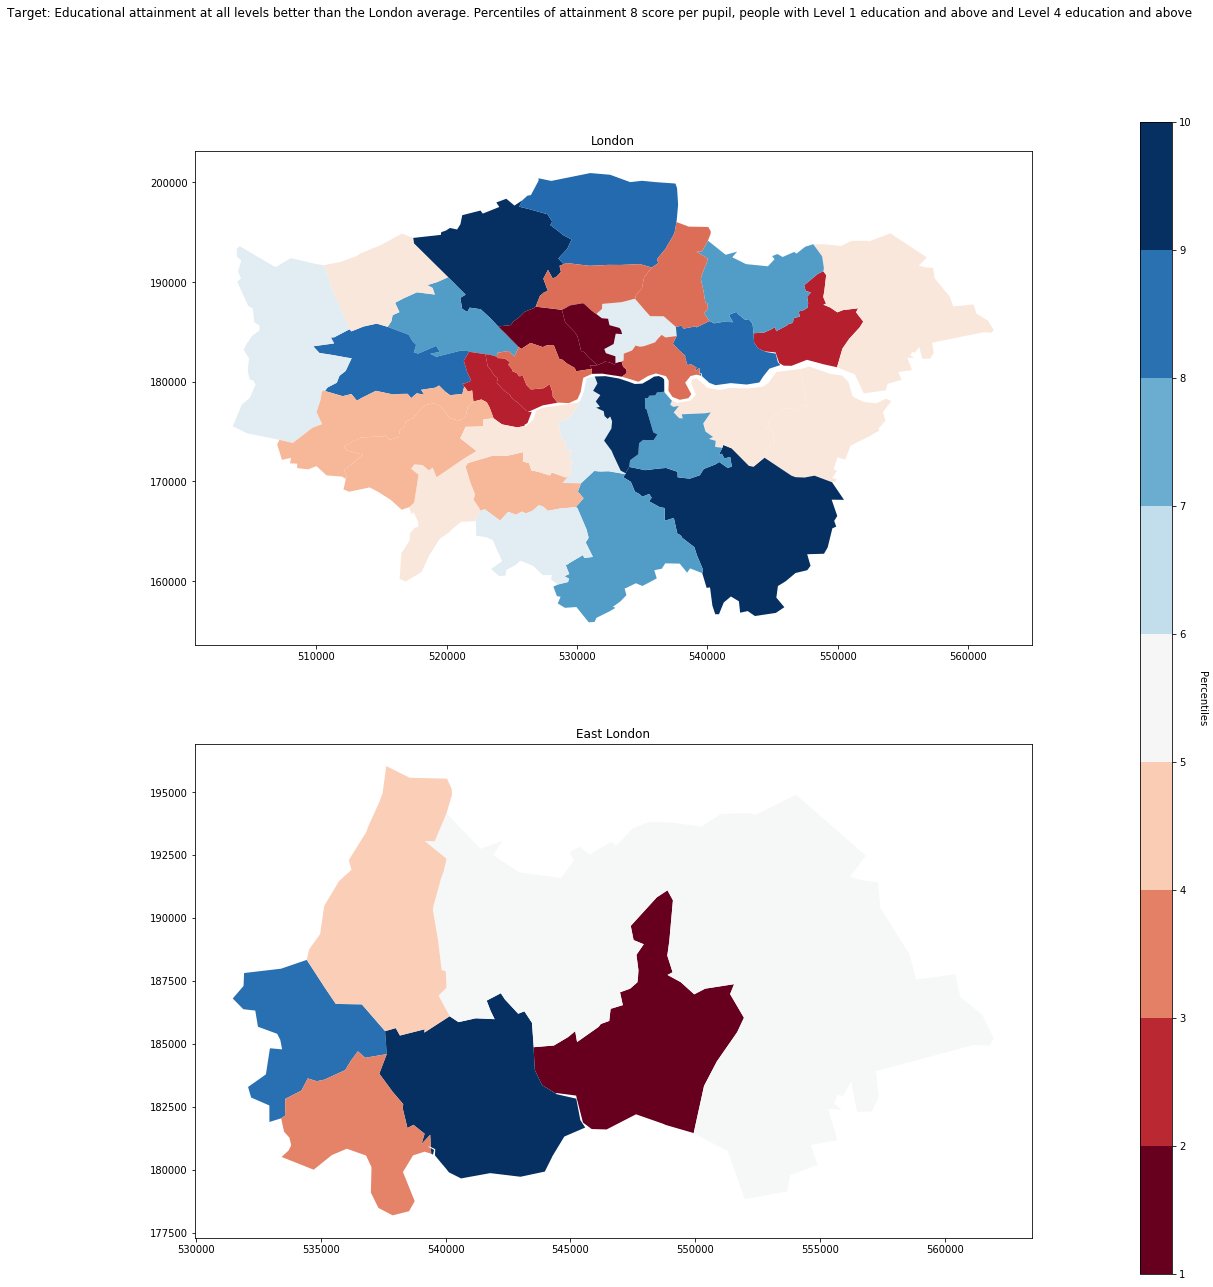

In [127]:
### Fields ###

### Defining our attributes and passing them to fields ###

### Average attainment 

average_attainment_attribute = AttributeMatcher(label='average_attainment',
                                                   provider='uk.gov.ons')
average_attainment = LatestValueField(attribute_matcher=average_attainment_attribute,
                                                label='average_attainment')

### Level 1 qualifications

level_1_qualifications_attribute = AttributeMatcher(label='Qualification: NVQ Level 1, Foundation GNVQ, Basic Skills',
                                                   provider='uk.gov.ons')
level_1_qualifications = LatestValueField(attribute_matcher=level_1_qualifications_attribute,
                                                label='Qualification: NVQ Level 1, Foundation GNVQ, Basic Skills')

### Level 4+ qualifications

level_4_qualifications_attribute = AttributeMatcher(label='Qualification: NVQ Level 4-5, HNC, HND, RSA Higher Diploma, BTEC Higher Level',
                                                   provider='uk.gov.ons')
level_4_qualifications = LatestValueField(attribute_matcher=level_4_qualifications_attribute,
                                                label='Qualification: NVQ Level 4-5, HNC, HND, RSA Higher Diploma, BTEC Higher Level')


### Tranforming them to percentiles after taking care of the missing values ###

fields = ['average_attainment','level_1_qualifications', 'level_4_qualifications']

f={}
for i in fields:
    f['geo_{0}'.format(i)] = GeographicAggregationField(subject=subject_geometry,
                                                           field=eval(('{0}').format(i)),
                                                           function='mean',
                                                           label='geo_{0}'.format(i))


    f['map_{0}'.format(i)] = MapToContainingSubjectField(field=f['geo_{0}'.format(i)],
                                                                   subject=Subject(subject_type_label='englandGeneralisedBoundaries',
                                                                                  provider_label='uk.gov.ons'),
                                                                   label='map_{0}'.format(i))

    f['backoff_{0}'.format(i)] = BackOffField(fields=[eval(('{0}').format(i)),
                                                             f['map_{0}'.format(i)]],
                                         label='backoff_{0}'.format(i))
    
    ### London wide normalisation
    
    f['percentile_{0}'.format(i)] = PercentilesField(field=f['backoff_{0}'.format(i)],
                                                     inverse=False,
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry],
                                                     label='percentile_{0}'.format(i))
    ### East London

    f['percentile_{0}_east_london'.format(i)] = PercentilesField(field=f['backoff_{0}'.format(i)],
                                                     inverse=False,
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry_east_london],
                                                     label='percentile_{0}'.format(i))

### Combining the resulting fields with a LinearCombinationField and convering the result to percentiles ###

combined_education = LinearCombinationField(fields=[f['percentile_average_attainment'],
                                                 f['percentile_level_1_qualifications'],
                                                 f['percentile_level_4_qualifications']],
                                         scalars = [1.,1.,1.],
                                         label='Educational attainment at all levels for London')

percentile_combined_education = PercentilesField(field=combined_education,
                                                     inverse=False,
                                                     label='Educational attainment at all levels for London',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry])

combined_education_east_london = LinearCombinationField(fields=[f['percentile_average_attainment_east_london'],
                                                 f['percentile_level_1_qualifications_east_london'],
                                                 f['percentile_level_4_qualifications_east_london']],
                                         scalars = [1.,1.,1.],
                                         label='Educational attainment at all levels for East London')

percentile_combined_education_east_london = PercentilesField(field=combined_education_east_london,
                                                     inverse=False,
                                                     label='Educational attainment at all levels for East London',
                                                     percentile_count=10,
                                                     normalization_subjects=[subject_geometry_east_london])

### Run the exporter and plot the result ###

dataset_london = Dataset(subjects=[subject_geometry], fields=[percentile_combined_education],
                  datasources=importers_list)

dataset_east_london = Dataset(subjects=[subject_geometry_east_london], fields=[percentile_combined_education_east_london],
                  datasources=importers_list)

output_file = 'barking-education-manifesto_london_py'

gradle_call = run_gradle(output_file, dataset_london)
gradle_call = run_gradle(output_file + '_east_london',
                                      dataset_east_london)

plot_result(gradle_call, output_file,
            percentile_combined_education,
            percentile_combined_education_east_london,
           'Target: Educational attainment at all levels better than the London average. Percentiles of attainment 8 score per pupil, people with Level 1 education and above and Level 4 education and above')


